In [1]:
'''Imports'''
from IPython.display import Audio, display, clear_output
from preamble import *

cwd = os.getcwd()
dataPath = os.path.join(cwd,'data')
savePath = os.path.join(cwd,'saves')

print('Current Working Directory:\n',cwd)
print('\nData Directory:\n',dataPath)
print('\nSaves Direcory:\n',savePath)

Current Working Directory:
 C:\Users\josh.galloway\Google Drive\Synch\Education\_Northeastern University\03_DS 5230 Unsup ML\99_Project\05_Code

Data Directory:
 C:\Users\josh.galloway\Google Drive\Synch\Education\_Northeastern University\03_DS 5230 Unsup ML\99_Project\05_Code\data

Saves Direcory:
 C:\Users\josh.galloway\Google Drive\Synch\Education\_Northeastern University\03_DS 5230 Unsup ML\99_Project\05_Code\saves


### Show Package Versions and Code to Download various Lexicons
Leave commented out unless needed.

In [2]:
# import sys
# import nltk
# import sklearn
# import matplotlib
# import scipy 
# import wordcloud

# print('Python version {}'.format(sys.version))
# print('Numpy version {}'.format(np.__version__))
# print('Matplotlib version {}'.format(matplotlib.__version__))
# print('Seaborn version {}'.format(sns.__version__))
# print('Pandas version {}'.format(pd.__version__))
# print('Scipy version {}'.format(scipy.__version__))
# print('nltk version {}'.format(nltk.__version__))
# print('scikit-learn version {}'.format(sklearn.__version__))
# print('wordcloud version {}'.format(wordcloud.__version__))


# # Get List of Stop Words
# nltk.download('stopwords')
# # Get Tokenizer
# nltk.download('punkt')
# # Get Wordnet Lemmatizer
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

versions = ['Python version 3.7.3\n\t(default, Mar 27 2019, 17:13:21)\n\t[MSC v.1915 64 bit (AMD64)]',
    'Numpy version 1.16.2',
    'Matplotlib version 3.0.3',
    'Seaborn version 0.10.1',
    'Pandas version 0.24.2',
    'Scipy version 1.4.1',
    'nltk version 3.5',
    'scikit-learn version 0.23.1',
    'wordcloud version 1.7.0']
print('='*10 + ' Package Versions ' + '='*10)
for v in versions:
    print(v)

========== Package Versions ==========
Python version 3.7.3
	(default, Mar 27 2019, 17:13:21)
	[MSC v.1915 64 bit (AMD64)]
Numpy version 1.16.2
Matplotlib version 3.0.3
Seaborn version 0.10.1
Pandas version 0.24.2
Scipy version 1.4.1
nltk version 3.5
scikit-learn version 0.23.1
wordcloud version 1.7.0


In [3]:
'''Save or recall objects'''
def pickle_object(obj, filename, save=True, addTime=False):
    if save:
        # save the results to disk
        if addTime:
            temp = filename.split('.')
            filename = temp[0] + datetime.now().strftime("%Y%m%d-%H%M%S")+'.' + temp[-1]
        pickle.dump(obj, open(filename, 'wb'))
        print("Saved File: ",filename)
        print('At Time: ',datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))
        return obj
    else:
        return pickle.load(open(filename, 'rb'))
    
'''Display Topics From LDA and NMF Models'''
def display_topics(model, feature_names, no_top_words):
    for i in range(len(model.components_[:,0])):
        print("Topic {:d} =====================".format(i))
        idx = (-model.components_[i,:]).argsort()[:no_top_words]
        print("|".join([feature_names[k] for k in idx]))
        
def display_centroids(model, feature_names, no_top_words):
    vs = vader.SentimentIntensityAnalyzer()
    for i in range(len(model.cluster_centers_[:,0])):
        print("Centroid {:d} =====================".format(i))
        idx = (-model.cluster_centers_[i,:]).argsort()[:no_top_words]
        print("|".join([feature_names[k] for k in idx]))
        print('Sentiment: ',
              vs.polarity_scores(" ".join([feature_names[k] for k in idx])))
          
beepFile = os.path.join(cwd,'data','Pager Beeps.mp3')
def done():
    '''Beep to get attention at end of code execution'''
    display(Audio(beepFile, autoplay=True))


def plot_dendrogram(data, title, linkage_='ward', model = None):
    '''Build Hierarchical Model and Plot Dendrogram'''
    # Create linkage matrix and then plot the dendrogram
    if model is None:
        model = AgglomerativeClustering(distance_threshold=0, 
                                        n_clusters=None, linkage=linkage_)
    model = model.fit(data)

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(15,7),facecolor='#d3d3d3')
    plt.title(title,fontweight='bold')
    dendrogram(linkage_matrix)
    plt.yticks([])
    _=plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    return model

def plot_clustering(cluster_centers_, data_df, title, angles, fsize=(15,15)):
    '''Plot Clustering with DataFrame columns neg, neu, pos, Label'''
    fig = plt.figure(tight_layout = True, figsize=fsize, facecolor='#d3d3d3')
    marks = ['o','^','s','*','x']
    lgd = 'Centroid {:d}'
    #angles = [(None,30),(10,90),(100,0),(10,0)]
    for j,angle in enumerate(angles):
        ax = fig.add_subplot(2,2,j+1, projection='3d')
        
        # buid dict for labels and colors
        lbls = {}
        for i,lbl in enumerate(set(data_df['Label'])):
            lbls[lbl] = i
        
        # Plot points
        for i, topic in enumerate(data_df[['neg','neu','pos']].values):
                cl = lbls[data_df['Label'].loc[i]]
                ax.scatter(topic[0], topic[1], topic[2],
                       c=COLORS[cl], marker=marks[cl], s=25)
        # Plot Centers or Ad
        if cluster_centers_ is None:
            # build custom legend
            le = []
            for key in lbls.keys():
                cl = lbls[key]
                le.append(Line2D([0], [0], marker=marks[cl], color=COLORS[cl],
                                 label=lgd.format(key), markerfacecolor=COLORS[cl],
                                 markersize=10))
            ax.legend(handles = le, loc='best')
        else:
            # Plot Centers as bigger markers
            for i, center in enumerate(cluster_centers_):
                ax.scatter(center[0], center[1], center[2],
                           c=COLORS[i], marker=marks[i], s=150,
                           label = lgd.format(i))
            ax.legend(loc='best')
        
        ax.set_xlabel('Negative Sentiment',fontweight='bold')
        ax.set_ylabel('Neutral Sentiment',fontweight='bold')
        ax.set_zlabel('Positive Sentiment',fontweight='bold')
        ax.set_title(title,fontweight='bold')
        ax.view_init(*angle)

## Load Datasets

In [4]:
abcFile = 'abcnews-date-text.csv'
redditFile = 'RedditNews.csv'
abcPath = os.path.join(dataPath,abcFile)
redditPath = os.path.join(dataPath,redditFile)

abcDF = pd.read_csv(str(abcPath))
redditDF = pd.read_csv(str(redditPath))
display(abcDF.head())
display(redditDF.head())

publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers

Date                                               News
0  2016-07-01  A 117-year-old woman in Mexico City finally re...
1  2016-07-01   IMF chief backs Athens as permanent Olympic host
2  2016-07-01  The president of France says if Brexit won, so...
3  2016-07-01  British Man Who Must Give Police 24 Hours' Not...
4  2016-07-01  100+ Nobel laureates urge Greenpeace to stop o...

## Clean and Sythesize in to one Dataframe

In [5]:
# Align Column Names
abcDF.columns = redditDF.columns
print('ABC Dataframe')
display(abcDF.info())
print('Reddit Dataframe')
display(redditDF.info())

ABC Dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186018 entries, 0 to 1186017
Data columns (total 2 columns):
Date    1186018 non-null int64
News    1186018 non-null object
dtypes: int64(1), object(1)
memory usage: 18.1+ MB


None

Reddit Dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73608 entries, 0 to 73607
Data columns (total 2 columns):
Date    73608 non-null object
News    73608 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


None

### Add Features to capture information that may be eliminated otherwise
Since we are about to alter the headlines from the original form and then combine them into one dataframe, add features to try to capture that data.  Similarly, as part of the cleaning process digits will be removed, so mark the headlines that have numbers.

In [6]:
# Add new features
hasNum = lambda x: int(bool(re.search(r'\d', x)) == True)

abcDF['Source'] = 'ABC'  # Set Source
abcDF['Length'] = abcDF.News.apply(len) # Save original headline length
abcDF['HasNumbers'] = abcDF.News.apply(hasNum)

redditDF['Source'] = 'Reddit'  # Set Source
redditDF['Length'] = redditDF.News.apply(len) # Save original headline length
redditDF['HasNumbers'] = redditDF.News.apply(hasNum)

print('ABC Dataframe')
display(abcDF.info())
print('Reddit Dataframe')
display(redditDF.info())

ABC Dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186018 entries, 0 to 1186017
Data columns (total 5 columns):
Date          1186018 non-null int64
News          1186018 non-null object
Source        1186018 non-null object
Length        1186018 non-null int64
HasNumbers    1186018 non-null int64
dtypes: int64(3), object(2)
memory usage: 45.2+ MB


None

Reddit Dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73608 entries, 0 to 73607
Data columns (total 5 columns):
Date          73608 non-null object
News          73608 non-null object
Source        73608 non-null object
Length        73608 non-null int64
HasNumbers    73608 non-null int64
dtypes: int64(2), object(3)
memory usage: 2.8+ MB


None

### Convert the Dates to Datetime objects

In [7]:
# Convert to Date Time 'Date' Column
abcDF.Date = pd.to_datetime(abcDF.Date,format='%Y%m%d')
redditDF.Date = pd.to_datetime(redditDF.Date,format='%Y-%m-%d')
print('ABC Dataframe')
display(abcDF.info())
print('Reddit Dataframe')
display(redditDF.info())

ABC Dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186018 entries, 0 to 1186017
Data columns (total 5 columns):
Date          1186018 non-null datetime64[ns]
News          1186018 non-null object
Source        1186018 non-null object
Length        1186018 non-null int64
HasNumbers    1186018 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 45.2+ MB


None

Reddit Dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73608 entries, 0 to 73607
Data columns (total 5 columns):
Date          73608 non-null datetime64[ns]
News          73608 non-null object
Source        73608 non-null object
Length        73608 non-null int64
HasNumbers    73608 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.8+ MB


None

### Combine into one Dataframe

In [8]:
# Combine in to one dataframe
totalDF = pd.concat([abcDF,redditDF], ignore_index=True)
display(totalDF.head())
display(totalDF.tail())
display(totalDF.info())
display(totalDF.describe())

Date                                               News Source  \
0 2003-02-19  aba decides against community broadcasting lic...    ABC   
1 2003-02-19     act fire witnesses must be aware of defamation    ABC   
2 2003-02-19     a g calls for infrastructure protection summit    ABC   
3 2003-02-19           air nz staff in aust strike for pay rise    ABC   
4 2003-02-19      air nz strike to affect australian travellers    ABC   

   Length  HasNumbers  
0      50           0  
1      46           0  
2      46           0  
3      40           0  
4      45           0

Date                                               News  Source  \
1259621 2008-06-08  b'Man goes berzerk in Akihabara and stabs ever...  Reddit   
1259622 2008-06-08  b'Threat of world AIDS pandemic among heterose...  Reddit   
1259623 2008-06-08  b'Angst in Ankara: Turkey Steers into a Danger...  Reddit   
1259624 2008-06-08  b"UK: Identity cards 'could be used to spy on ...  Reddit   
1259625 2008-06-08  b'Marriage, they said, was reduced to the stat...  Reddit   

         Length  HasNumbers  
1259621      79           1  
1259622      75           0  
1259623      66           0  
1259624     171           0  
1259625     175           0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259626 entries, 0 to 1259625
Data columns (total 5 columns):
Date          1259626 non-null datetime64[ns]
News          1259626 non-null object
Source        1259626 non-null object
Length        1259626 non-null int64
HasNumbers    1259626 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 48.1+ MB


None

Length    HasNumbers
count  1.259626e+06  1.259626e+06
mean   4.478764e+01  8.092402e-02
std    2.550213e+01  2.727185e-01
min    3.000000e+00  0.000000e+00
25%    3.400000e+01  0.000000e+00
50%    4.200000e+01  0.000000e+00
75%    4.900000e+01  0.000000e+00
max    3.180000e+02  1.000000e+00

## Clean the Headlines and Create New Column for the Altered Data

In [9]:
# Clean Dataframe

# All to lower case
t0 = time()
print('\nSetting all to lowercase...')
totalDF['Cleaned'] = totalDF.News.apply(str.lower)
print("done in %0.3fs." % (time() - t0))

# Remove Punctuation
remPunct = lambda x: x.translate(str.maketrans('', '', punctuation))
t0 = time()
print('\nRemoving punctuation...')
totalDF.Cleaned = totalDF.Cleaned.apply(remPunct)
print("done in %0.3fs." % (time() - t0))

# Remove Numbers
remNum = lambda x: x.translate(str.maketrans('', '', digits))
t0 = time()
print('\nRemoving numbers...')
totalDF.Cleaned = totalDF.Cleaned.apply(remNum)
print("done in %0.3fs." % (time() - t0))

# Get list of Stop words with punctuation removed
nopunctStopwords = [w.translate(str.maketrans('', '', punctuation)) for w in stopwords.words('english')]
remStop  = lambda x: ' '.join([w for w in x.split() if w not in nopunctStopwords])
t0 = time()
print('\nRemoving stopwords...')
totalDF.Cleaned = totalDF.Cleaned.apply(remStop)
print("done in %0.3fs." % (time() - t0))

# Lemmatize or Stem Words
wnl = WordNetLemmatizer()
ps = PorterStemmer()
lemma = lambda x: ' '.join([wnl.lemmatize(t) for t in word_tokenize(x)])
stemm = lambda x: ' '.join([ps.stem(t) for t in word_tokenize(x)])
t0 = time()
print('\nLemmatizing/Stemming words...')
totalDF.Cleaned = totalDF.Cleaned.apply(lemma)
print("Completed in %0.3fs." % (time() - t0))

display(totalDF.head())
done()


Setting all to lowercase...
done in 0.307s.

Removing punctuation...
done in 3.657s.

Removing numbers...
done in 2.491s.

Removing stopwords...
done in 15.565s.

Lemmatizing/Stemming words...
Completed in 129.570s.


Date                                               News Source  \
0 2003-02-19  aba decides against community broadcasting lic...    ABC   
1 2003-02-19     act fire witnesses must be aware of defamation    ABC   
2 2003-02-19     a g calls for infrastructure protection summit    ABC   
3 2003-02-19           air nz staff in aust strike for pay rise    ABC   
4 2003-02-19      air nz strike to affect australian travellers    ABC   

   Length  HasNumbers                                     Cleaned  
0      50           0  aba decides community broadcasting licence  
1      46           0      act fire witness must aware defamation  
2      46           0     g call infrastructure protection summit  
3      40           0           air nz staff aust strike pay rise  
4      45           0   air nz strike affect australian traveller

### Save off Dataframe for Later Recall

In [10]:
# # Save off the Dataframe object
# pickleFile = os.path.join(savePath,'cleanedData.sav')
# csvFile = os.path.join(savePath,'cleanedData.csv')

# pickle_object(totalDF, str(pickleFile), save=True, addTime=False)
# totalDF.to_csv(str(csvFile),index=False)

### Create term frequency–inverse document frequency and term frequency matricies for LSI, PLSI and LDA
Set tokenizer to use Unigrams and Bigrams

In [11]:
no_features = 2000 # Number of words to truncate vocabulary, chosen arbitrarily

# SVD and NMF are able to use tf-idf
t0 = time()
print('\nCreating TF-IDF Matrix...')
tfidf_vectorizer = TfidfVectorizer(max_features=no_features,
                                   lowercase=False, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(totalDF.Cleaned)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("Completed in %0.3fs." % (time() - t0))


# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
t0 = time()
print('\nCreating TF Matrix...')
tf_vectorizer = CountVectorizer(max_features=no_features,
                                lowercase=False, ngram_range=(1,2))
tf = tf_vectorizer.fit_transform(totalDF.Cleaned)
tf_feature_names = tf_vectorizer.get_feature_names()
print("Completed in %0.3fs." % (time() - t0))
done()


Creating TF-IDF Matrix...
Completed in 20.257s.

Creating TF Matrix...
Completed in 20.781s.


### Visualize the terms and find average length of headline

TF-TDF Matrix Size:  (1259626, 2000)
TF-IDF Feature Set Avearge Word Length:  6
TF-IDF Feature Set Avearge Headline Words:  7.5
TF Matrix Size:  (1259626, 2000)
TF Feature Set Avearge Word Length:  6
TF Feature Set Avearge Headline Words:  7.5


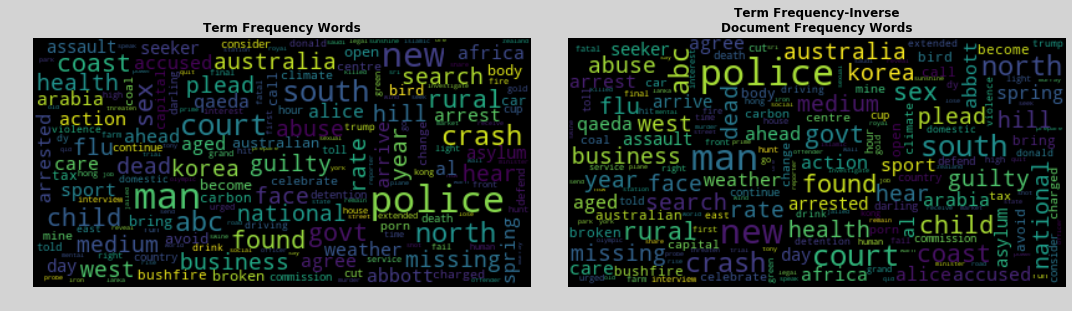

In [87]:
# Find Average Length of word in feature set
charLenAvg = round(totalDF.Length.mean())
avg = 0
for w in tfidf_feature_names:
    avg = len(w) + avg
print('TF-TDF Matrix Size: ',tfidf.shape)
print('TF-IDF Feature Set Avearge Word Length: ',round(avg/len(tfidf_feature_names)))
print('TF-IDF Feature Set Avearge Headline Words: ',charLenAvg/round(avg/len(tfidf_feature_names)))

avg = 0
for w in tf_feature_names:
    avg = len(w) + avg
    
print('TF Matrix Size: ',tf.shape)
print('TF Feature Set Avearge Word Length: ',round(avg/len(tf_feature_names)))
print('TF Feature Set Avearge Headline Words: ',charLenAvg/round(avg/len(tf_feature_names)))


# plot wordcloud
plt.figure(tight_layout = True, figsize = (15, 8), facecolor = '#d3d3d3')
titles = ['Term Frequency Words','Term Frequency-Inverse\nDocument Frequency Words']
wc = WordCloud(background_color ='black', min_font_size = 5,max_font_size=30)
for i,terms in enumerate([tf_feature_names, tfidf_feature_names]):
    # plot the WordCloud image
    wc.generate(' '.join(terms))
    plt.subplot(1,2,i+1)
    plt.imshow(wc, interpolation='bilinear') 
    plt.axis("off") 
    plt.title(titles[i],fontweight='bold') 
 

### Save TF and TF-IDF Sparse Matricies for Later Recall

In [13]:
# # Save TF Matix
# pickle_object(tf_feature_names,str(os.path.join(savePath,'TF_Features.sav')),
#               save=True,addTime=False)
# pickle_object(tf,str(os.path.join(savePath,'TFMatix.sav')),
#               save=True,addTime=False)

# # Save TF-IDF Matrix
# pickle_object(tfidf_feature_names,str(os.path.join(savePath,'TFIDF_Features.sav')),
#               save=True,addTime=False)
# pickle_object(tfidf,str(os.path.join(savePath,'TFIDFMatrix.sav')),
#               save=True,addTime=False)

## Create Test Train Split Stratified By Source

In [14]:
np.random.seed(42)
idx_train, idx_test = train_test_split(totalDF.index.values,
                                                    stratify=totalDF.Source, 
                                                    test_size=0.25)
print('Original Dataset Sources: ')
cnts = totalDF.Source.value_counts()
print(cnts)
print('ABC: ',cnts['ABC']/len(totalDF.index)*100,'Reddit: ',cnts['Reddit']/len(totalDF.index)*100)
print('\nTraining Set Sources: ')
cnts = totalDF.loc[idx_train].Source.value_counts()
print(cnts)
print('ABC: ',cnts['ABC']/len(idx_train)*100,'Reddit: ',cnts['Reddit']/len(idx_train)*100)
print('\nTest Set Sources: ')
cnts = totalDF.loc[idx_test].Source.value_counts()
print(cnts)
print('ABC: ',cnts['ABC']/len(idx_test)*100,'Reddit: ',cnts['Reddit']/len(idx_test)*100)


Original Dataset Sources: 
ABC       1186018
Reddit      73608
Name: Source, dtype: int64
ABC:  94.15636069754038 Reddit:  5.843639302459619

Training Set Sources: 
ABC       889513
Reddit     55206
Name: Source, dtype: int64
ABC:  94.15635760474808 Reddit:  5.843642395251922

Test Set Sources: 
ABC       296505
Reddit     18402
Name: Source, dtype: int64
ABC:  94.15636997589765 Reddit:  5.843630024102354


## Build Latent Sementic Analysis to find Optimal Number of Topics

In [15]:
# Build a Latent Semantic Indexing Model using SVD
t0 = time()
print('\nCreating LSA/SVD Model...')
lsa_model = TruncatedSVD(n_components=500)
lsa = lsa_model.fit_transform(tfidf[idx_train,:])
print("Completed in %0.3fs." % (time() - t0))
done()


Creating LSA/SVD Model...
Completed in 335.923s.


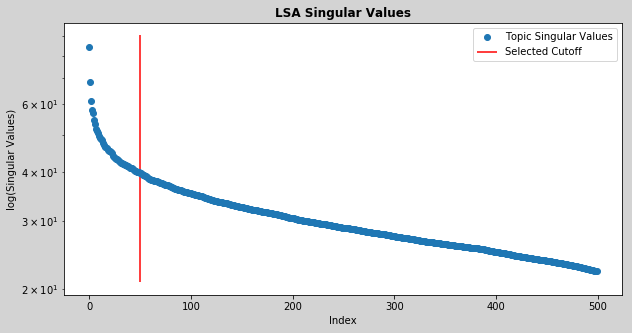

In [16]:
# Plot Results to Find Knee
plt.figure(figsize=(10,5),facecolor='#d3d3d3')
plt.semilogy(lsa_model.singular_values_,'o',label='Topic Singular Values')
plt.vlines(50,*plt.ylim(),'r',label='Selected Cutoff')
plt.ylabel('log(Singular Values)')
plt.xlabel('Index')
_ = plt.title('LSA Singular Values',fontweight='bold')
plt.legend(loc='best')

### Save LSA Model for Later Recall

In [17]:
# # Save LSA Model
# pickle_object(lsa_model, str(os.path.join(savePath,'lsa500TopicModel.sav')),
#                            save=True, addTime=False)

## Build Latent Dirichlet Allocation Model
Build model using 50 topics as estimated roughly from the LSA model singular values.

In [18]:
# Build LDA Model
n_topics = 50 # number of topics in topic model

print("Fitting LDA models with tf features, "
      "n_samples = %d and n_features = %d..."
      % (tf[idx_train,:].shape[0],tf[idx_train,:].shape[1]))
lda = LatentDirichletAllocation(n_components=50, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf[idx_train,:])
print("Completed in %0.3fs." % (time() - t0))
done()

Fitting LDA models with tf features, n_samples = 944719 and n_features = 2000...
Completed in 634.803s.


### Save LDA Model for Later Recall

In [19]:
# # Save LDA Model
# pickle_object(lda, str(os.path.join(savePath,'lda50TopicModel.sav')),
#             save=True, addTime=False)

### Inspect Topics from LDA Model

In [20]:
print("\nTopics in LDA model:")
display_topics(lda, tf_feature_names, 9)


Topics in LDA model:
Topic 0 =====================
wa|national|rise|labor|rate|boy|bus|nz|flu
Topic 1 =====================
north|pay|force|industry|strike|safety|mining|blue|debate
Topic 2 =====================
one|family|driver|arrested|japan|men|girl|break|sea
Topic 3 =====================
man|child|charged|country|hope|hour|city|four|shooting
Topic 4 =====================
abc|canberra|welcome|hill|cancer|expert|defence|staff|research
Topic 5 =====================
murder|set|road|make|trial|brisbane|sign|give|nuclear
Topic 6 =====================
drug|service|station|violence|target|stop|release|raid|impact
Topic 7 =====================
face|go|public|community|rule|game|risk|black|truck
Topic 8 =====================
woman|accused|dead|melbourne|lead|sex|study|chinese|spark
Topic 9 =====================
farmer|time|young|award|nrl|level|online|story|used
Topic 10 =====================
police|found|missing|union|find|search|life|body|doctor
Topic 11 =====================
back|hospit

## Build Non-negative Matrix Factorization/ Probabilistic Latent Semantic Analysis Topic Model
NMF with beta loss set to KL divergence is equivalent to PLSA. Use 50 topics as before. Per for search over ratio of L1 to L2 norm used in distance calculation and find optimal value based on reconstruction error for a randomly sampled smaller dataset and then, train full on that value.

In [21]:
'''Setup Grid Search'''
def create_model(n_topics_ = 50, max_iter_ = 100, alpha_ = 0.1,l1_ratio_=0.5):
    '''Build Tunable Model Function'''
    model = NMF(n_components=n_topics_, random_state=42,
              beta_loss='kullback-leibler', solver='mu', init = 'random',
                max_iter=max_iter_, alpha=alpha_, l1_ratio=l1_ratio_)        
    return model

In [22]:
'''Setup Search Parameters'''
_alpha = np.linspace(0.8,1,10)
_l1_ratio = np.linspace(0,0.2,10)
AA, LL = np.meshgrid(_alpha,_l1_ratio)
aa, ll = AA.flatten(), LL.flatten()

# Build Small Test Set
np.random.seed(42)
_waste, idx_grid = train_test_split(idx_train, stratify=totalDF.loc[idx_train].Source, 
                                                    test_size=0.05)
'''Start Grid Search'''
nt = 5
print('Grid Search Sample Set Size: ',len(idx_grid))
print('Topics for Grid Search: ',nt)
print('Beginning grid search on %d paramerter combinations...' % (len(aa)))
results = []
t0 = time()
for i in range(len(aa)):
    t1 = time()
    mdl = create_model(n_topics_ = nt, max_iter_ = 100,
                 alpha_ = aa[i], l1_ratio_ = ll[i])
    print('\nLoop %d, alpha = %0.3f, l1_ratio = %0.3f' % (i, aa[i], ll[i]))
    mdl.fit(tfidf[idx_grid,:])
    merr = mdl.reconstruction_err_
    results.append([aa[i],ll[i],merr])
    print('Loop completed in %0.3fs. Error: %0.6f' %(time() - t1, merr))

clear_output(wait=True)
print("Completed in %0.3fs." % (time() - t0))

'''Display Results'''
df = pd.DataFrame(results,columns=['Alpha','L1 Ratio', 'Error'])
df.Error = (df.Error - df.Error.mean())/(df.Error.std())
display(df.loc[df.Error.idxmin()])
done()

Completed in 793.911s.


Alpha       0.977778
L1 Ratio    0.000000
Error      -2.121364
Name: 8, dtype: float64

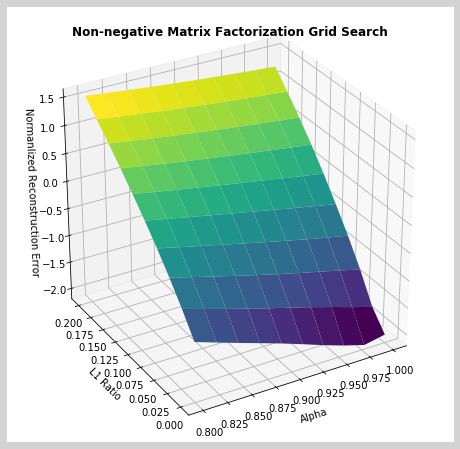

In [23]:
'''Plot Results of Grid Search'''
fig = plt.figure(figsize=(8,8), facecolor='#d3d3d3')
ax = fig.add_subplot(111, projection='3d')
Z = df.values[:,2].reshape(AA.shape)
#ax.plot_wireframe(AA, LL, Z, cmap='viridis', rstride=1, cstride=1)
ax.plot_surface(AA, LL, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('Alpha')
ax.set_ylabel('L1 Ratio')
ax.set_zlabel('Normanlized Reconstruction Error')
ax.set_title('Non-negative Matrix Factorization Grid Search', 
             fontweight='bold')
ax.view_init(None, -120)

In [24]:
# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (tfidf[idx_train,:].shape[0],tfidf[idx_train,:].shape[1]))
t0 = time()

# W is document membership weights (returned via transform), ...
# ... H is topic word dictionary (model.components_)
nmfKL = NMF(n_components=n_topics, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=0.977,
          l1_ratio=0)
nmf_doc_member_weights = nmfKL.fit_transform(tfidf[idx_train,:])
print("Completed in %0.3fs." % (time() - t0))
done()

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=944719 and n_features=2000...
Completed in 475.833s.


### Save NMF Model for Later Recall

In [25]:
# # Save nmf Model
# pickle_object(nmfKL, str(os.path.join(savePath,'nmfTopicModel.sav')),
#         save=True, addTime=False)

### Inspect Topics from PLSA Model

In [26]:
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
display_topics(nmfKL, tfidf_feature_names, 9)


Topics in NMF model (generalized Kullback-Leibler divergence):
Topic 0 =====================
interview|john|nrl|david|michael|smith|peter|scott|james
Topic 1 =====================
security|stop|uk|rescue|fined|gun|bay|illegal|link
Topic 2 =====================
port|give|crisis|demand|rudd|meeting|development|shire|see
Topic 3 =====================
police|probe|chief|officer|arrest|station|investigate|hunt|target
Topic 4 =====================
new|name|zealand|new zealand|new year|york|new york|technology|cabinet
Topic 5 =====================
say|man|man charged|charged|man jailed|expert|need|man arrested|stabbing
Topic 6 =====================
win|tour|england|award|star|title|race|king|stage
Topic 7 =====================
fire|house|force|warning|threat|season|blaze|bushfire|risk
Topic 8 =====================
call|inquiry|opposition|review|medium|spark|prompt|fiji|better
Topic 9 =====================
australia|india|free|indonesia|pacific|nz|northern|refugee|indian
Topic 10 ============

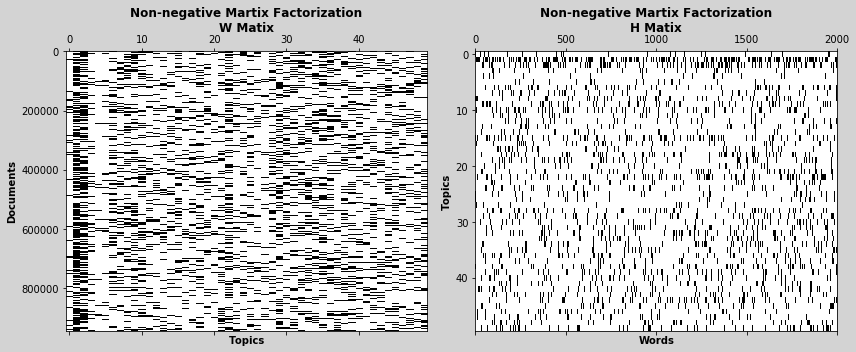

In [27]:
#np.argsort(nmf_doc_member_weights[:,range(len(nmfKL.components_[:,0]))])[:,:-1].shape
nmf_doc_member_weights.shape
fig = plt.figure(tight_layout = True,figsize=(12,5),
                 facecolor='#d3d3d3')
ax = fig.add_subplot(121)
ax.spy(nmf_doc_member_weights)
ax.set_aspect('auto')
ax.set_title('Non-negative Martix Factorization\nW Matix', fontweight = 'bold')
ax.set_ylabel('Documents', fontweight = 'bold')
ax.set_xlabel('Topics', fontweight = 'bold')

ax = fig.add_subplot(122)
ax.spy(nmfKL.components_)
ax.set_aspect('auto')
ax.set_title('Non-negative Martix Factorization\nH Matix', fontweight = 'bold')
ax.set_ylabel('Topics', fontweight = 'bold')
_=ax.set_xlabel('Words', fontweight = 'bold')

## Calculate Sentiment Scores for LDA and PLSA/NMF Topics

In [28]:
# Score each topic for sentiment
cutoff = 0.1
nmf_sent = []
vs = vader.SentimentIntensityAnalyzer()
for i in range(len(nmfKL.components_[:,0])):
    x = np.argwhere(nmfKL.components_[i,:] > cutoff).ravel()
    nmf_sent.append(vs.polarity_scores(" ".join([tfidf_feature_names[xi] for xi in x])))

nmf_sent_df = pd.DataFrame(nmf_sent)

In [29]:
# Score each topic for sentiment
cutoff = 0.1
lda_sent = []
vs = vader.SentimentIntensityAnalyzer()
for i in range(len(lda.components_[:,0])):
    x = np.argwhere(lda.components_[i,:] > cutoff).ravel()
    lda_sent.append(vs.polarity_scores(" ".join([tf_feature_names[xi] for xi in x])))

lda_sent_df = pd.DataFrame(lda_sent)
lda_sent_df.head()

compound    neg    neu    pos
0   -0.6369  0.215  0.670  0.115
1    0.3612  0.143  0.724  0.133
2   -0.5106  0.147  0.713  0.140
3   -0.7845  0.265  0.603  0.132
4    0.1280  0.190  0.599  0.212

## Visualize Distribution for LDA and PLSA/NMF Sentiment Scores
### 1. LDA Sentiment

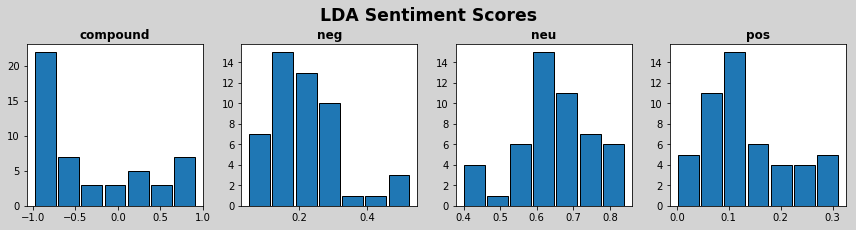

In [30]:
def plot_sent_hist(df,title,fsize = (12,3)):
    n_bins = int(np.ceil(1 + 3.22*np.log10(len(df))))
    f,axes = plt.subplots(nrows=1, ncols=4, tight_layout = True, figsize = fsize,
                          facecolor='#d3d3d3')
    df.hist(bins=n_bins, ax= axes, rwidth=0.9, align='mid',ec='k',grid=False)
    for ax in axes.ravel():
        ax.set_title(ax.get_title(),fontweight='bold')
    _ = f.suptitle(title,fontweight='bold', 
                  x=0.5, y=1.05, ha='center', fontsize='xx-large')

plot_sent_hist(lda_sent_df,'LDA Sentiment Scores')

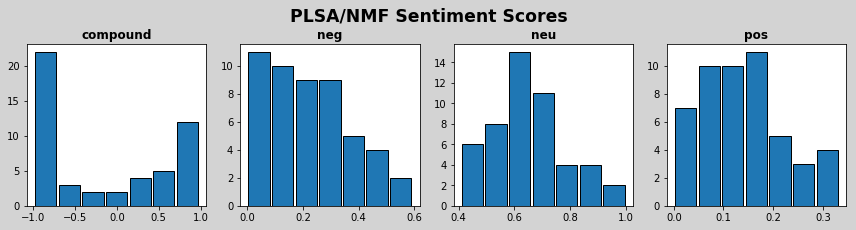

In [31]:
plot_sent_hist(nmf_sent_df,'PLSA/NMF Sentiment Scores')

# Hierarchical Clustering
***
## Hierarchical Clustering for LDA Topics

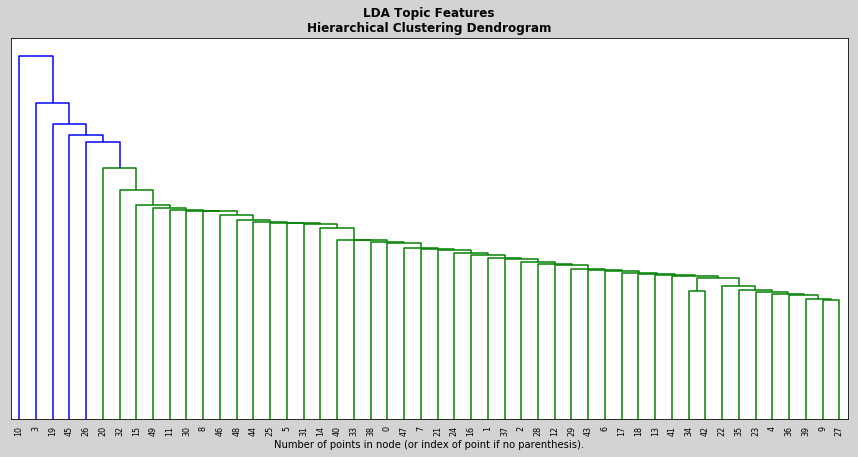

In [32]:
# copy dataframes
hc_lda_df = lda_sent_df.copy(deep=True)
hc_nmf_df = nmf_sent_df.copy(deep=True)

_ = plot_dendrogram(lda.components_,
                'LDA Topic Features\nHierarchical Clustering Dendrogram')

## Hierarchical Clustering LDA Topic Sentiments

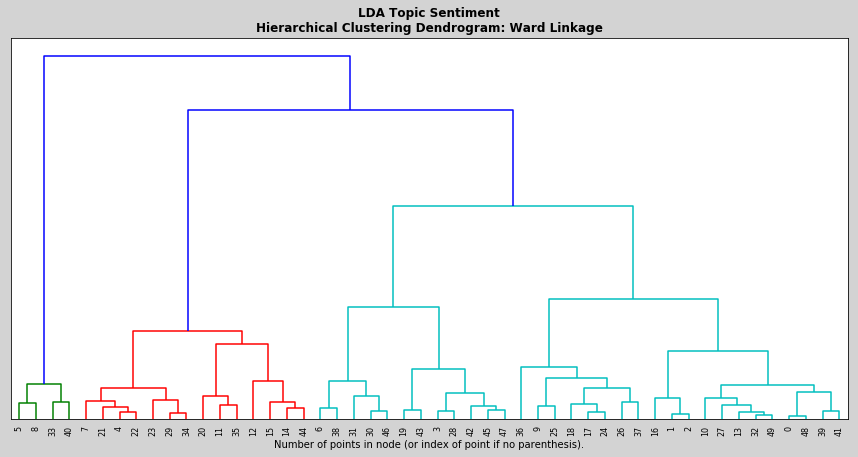

In [33]:
_ = plot_dendrogram(hc_lda_df[['neg','neu','pos']],
               'LDA Topic Sentiment\nHierarchical Clustering Dendrogram: Ward Linkage')

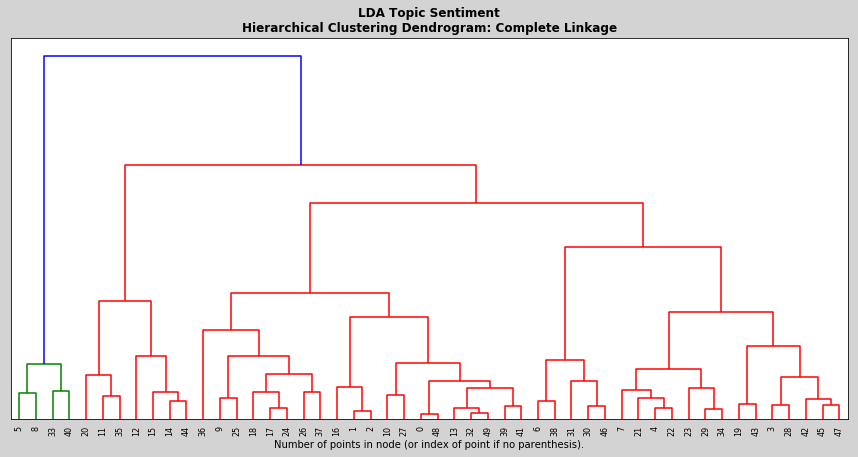

In [34]:
_ = plot_dendrogram(hc_lda_df[['neg','neu','pos']],
               'LDA Topic Sentiment\nHierarchical Clustering Dendrogram: Complete Linkage',
               linkage_ = 'complete')

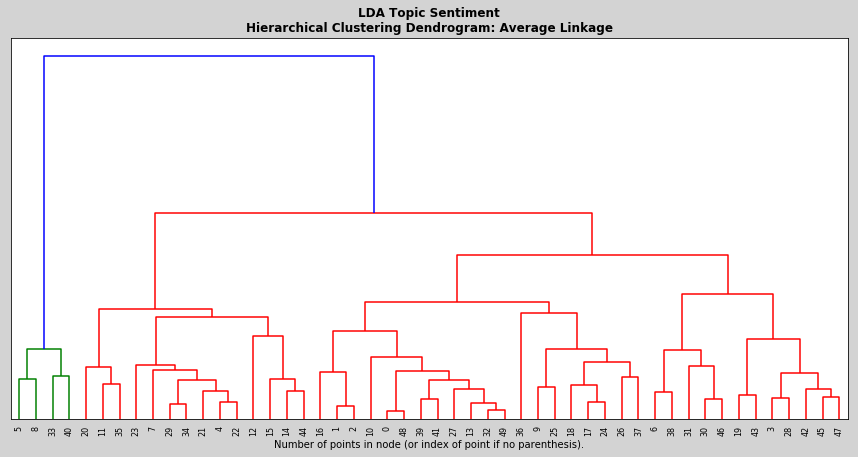

In [35]:
_ = plot_dendrogram(hc_lda_df[['neg','neu','pos']],
               'LDA Topic Sentiment\nHierarchical Clustering Dendrogram: Average Linkage',
               linkage_ = 'average')

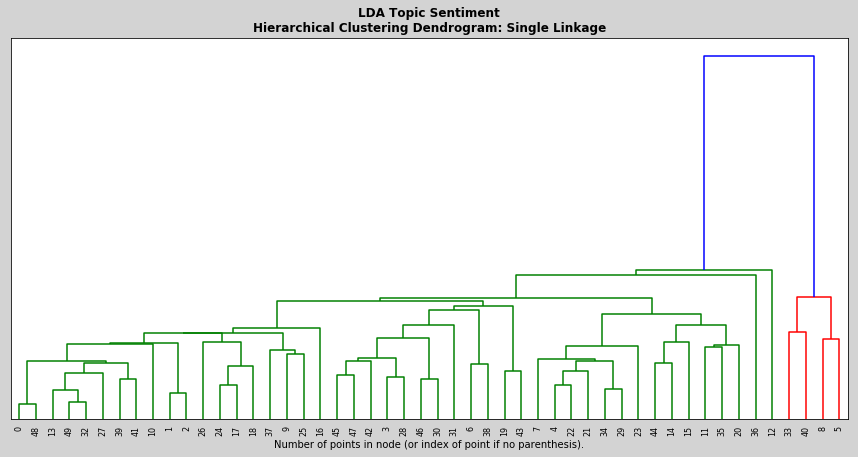

In [36]:
_ = plot_dendrogram(hc_lda_df[['neg','neu','pos']],
               'LDA Topic Sentiment\nHierarchical Clustering Dendrogram: Single Linkage',
               linkage_ = 'single')

## Hierarchical Clustering for NMF Topics

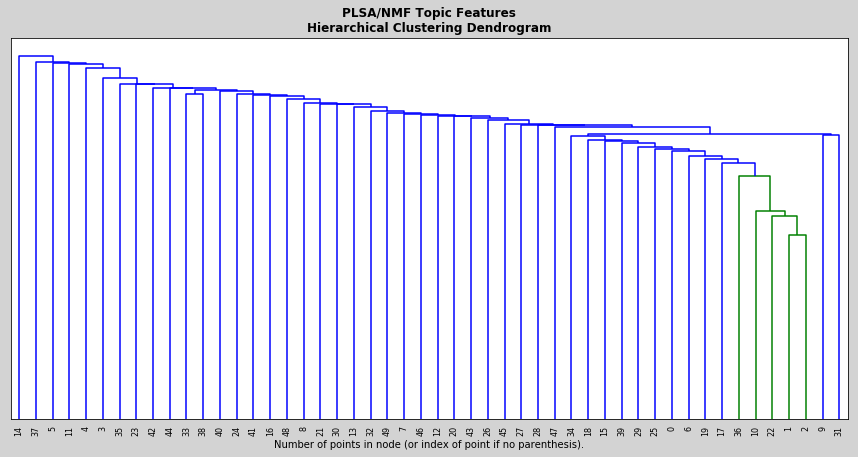

In [37]:
_ = plot_dendrogram(nmfKL.components_,
                'PLSA/NMF Topic Features\nHierarchical Clustering Dendrogram')

## Hierarchical Clustering for NMF Topic Sentiments

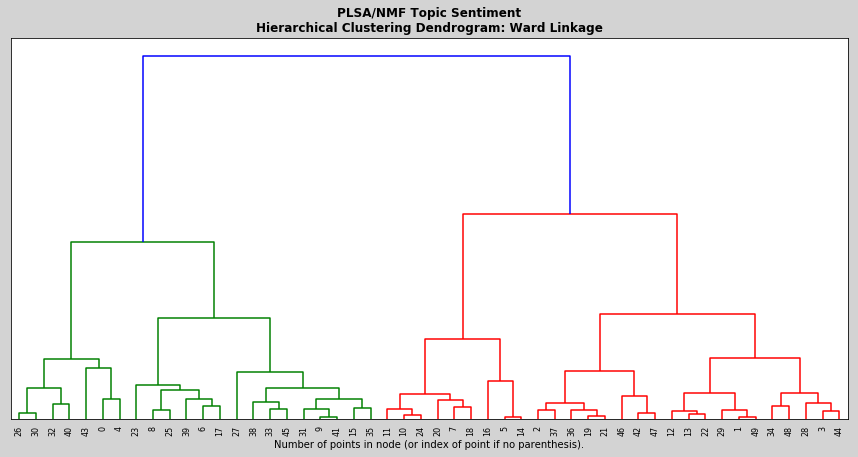

In [38]:
_ = plot_dendrogram(hc_nmf_df[['neg','neu','pos']],
               'PLSA/NMF Topic Sentiment\nHierarchical Clustering Dendrogram: Ward Linkage')

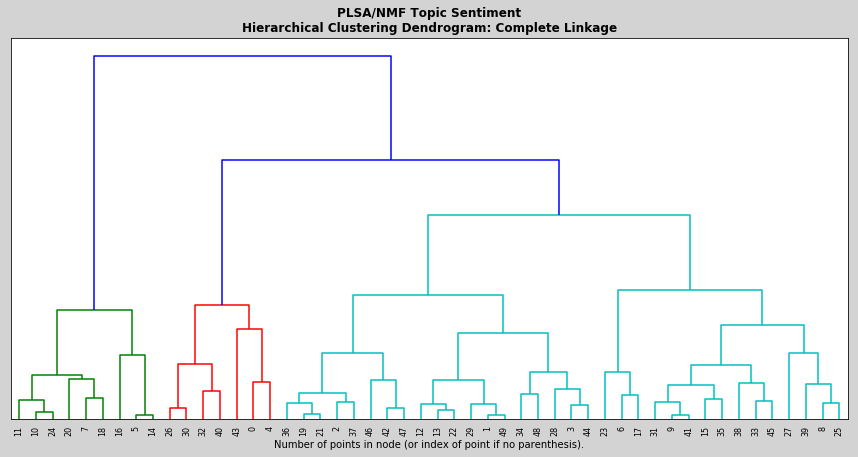

In [39]:
_ = plot_dendrogram(hc_nmf_df[['neg','neu','pos']],
               'PLSA/NMF Topic Sentiment\nHierarchical Clustering Dendrogram: Complete Linkage',
               linkage_='complete')

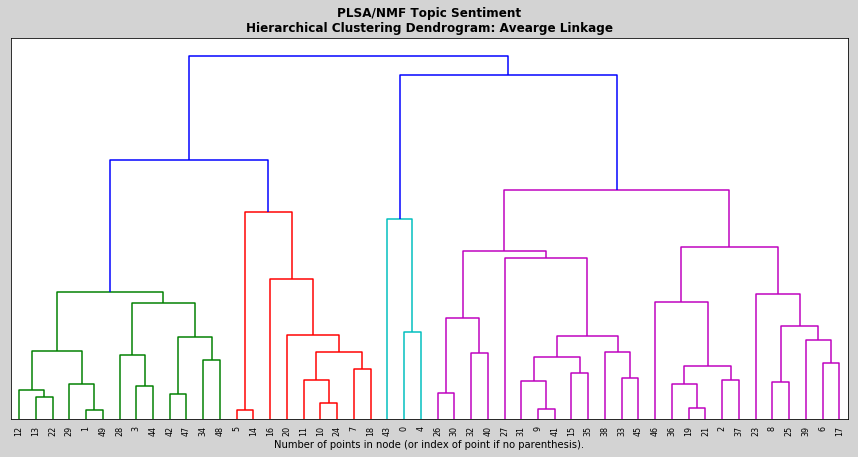

In [40]:
_ = plot_dendrogram(hc_nmf_df[['neg','neu','pos']],
               'PLSA/NMF Topic Sentiment\nHierarchical Clustering Dendrogram: Avearge Linkage',
               linkage_ = 'average')

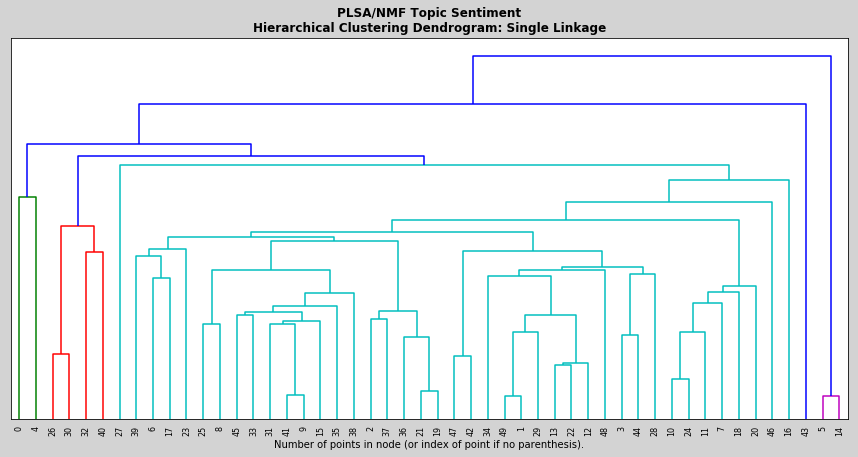

In [41]:
_ = plot_dendrogram(hc_nmf_df[['neg','neu','pos']],
               'PLSA/NMF Topic Sentiment\nHierarchical Clustering Dendrogram: Single Linkage',
               linkage_ = 'single')

## Heirarchical Clustering with LDA and PLSA/NMF Topic Sentiments

In [42]:
def heirarchical_wrapper(df, n_clusters_, msg):
    # Perform Clustering
    t0 = time()
    print('Beginning Hierarchical Clustering on %s Data with %d clusters...' % (msg,n_clusters_))
    mdl = AgglomerativeClustering(n_clusters = n_clusters_)
    mdl.fit(df[['neg','neu','pos']])
    # Label Topics
    df['Label'] = mdl.labels_
    print("completed in %0.3fs" % (time() - t0))
    return mdl, df

In [43]:
# Perform Clustering
hc_lda_clusters = 4
hc_nmf_clusters = 4

hc_lda, hc_lda_df = heirarchical_wrapper(hc_lda_df,hc_lda_clusters,'LDA')
hc_nmf, hc_nmf_df = heirarchical_wrapper(hc_nmf_df,hc_nmf_clusters, 'PLSA/NMF')
done()

Beginning Hierarchical Clustering on LDA Data with 4 clusters...
completed in 0.004s
Beginning Hierarchical Clustering on PLSA/NMF Data with 4 clusters...
completed in 0.003s


## Plot Results of Heirarchical Clustering

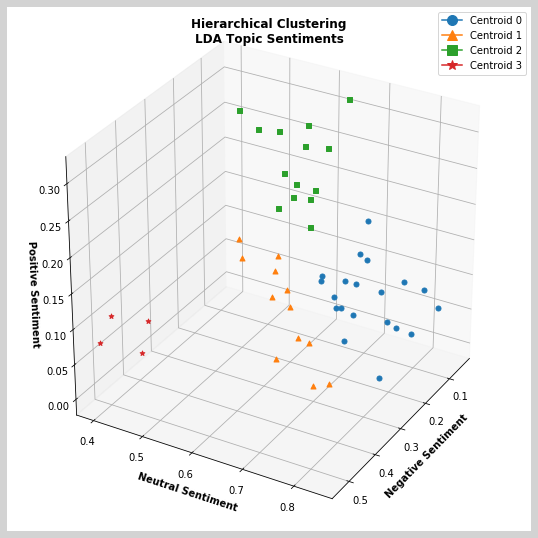

In [44]:
# Plot the results
ang = [(None,30)] #,(10,90),(100,0),(10,0)]
plot_clustering(None,
                hc_lda_df,'Hierarchical Clustering\nLDA Topic Sentiments',
                ang)

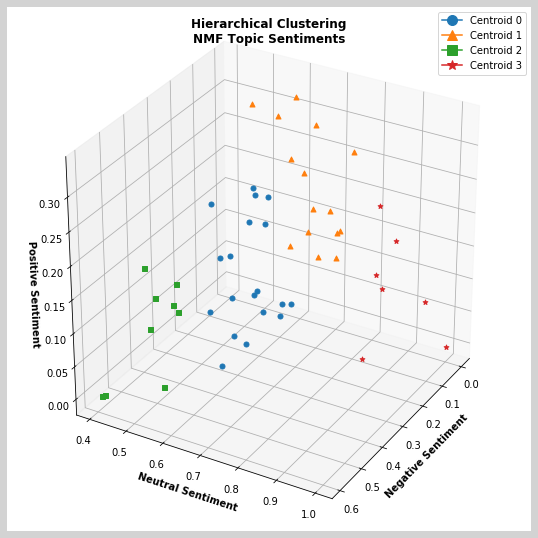

In [45]:
# Plot the results
ang = [(None,30)] #,(10,90),(100,0),(10,0)]
plot_clustering(None,
                hc_nmf_df,'Hierarchical Clustering\nNMF Topic Sentiments',
                ang)

## Score Hierarchical Clustering Models

In [46]:
def score_model(df):
    ch_score = calinski_harabasz_score(df[['neg','neu','pos']],
                                       df['Label'])
    sil_score = silhouette_score(df[['neg','neu','pos']],
                                 df['Label'],metric='euclidean')
    return np.array([ch_score,sil_score])

In [47]:
# Create DataFrame to Tabulate Model Scores
model_scores_df = pd.DataFrame(np.vstack([np.append(score_model(hc_lda_df),hc_lda_clusters),
                                          np.append(score_model(hc_nmf_df),hc_nmf_clusters)]).T,
                               index = ['CH Score', 'Silhouette Score','# Clusters'],
                               columns = ['Hierarchical LDA','Hierarchical PLSA/NMF'])
model_scores_df

Hierarchical LDA  Hierarchical PLSA/NMF
CH Score                 63.920187              59.160354
Silhouette Score          0.464105               0.391698
# Clusters                4.000000               4.000000

#### Heirachrical Clustering Summary
From the dendrograms, it's clear that clustering should be done on the sentiment scores for each topic. This makes sense as the dimensionality reduction to 50 topics is done to identify strickly unique sentiments/feature vectors.  The complete linkage calculation creates the best looking clustering per the vertical distance between levels. Complete or maximum linkage uses the maximum distances between all observations of the two sets.

The heirachrical clustering shows that 2-4 clusters are appropriate. 4 was used as it seems the best choice.


***
# KMeans Clustering
***
## Perform KMeans Clustering and Record Sum of Squared Error for Several Numbers of Clusters on LDA and PLSA/NMF Topic Sentiments

In [48]:
# copy dataframe
km_lda_df = lda_sent_df.copy(deep=True)
km_nmf_df = nmf_sent_df.copy(deep=True)

def run_nclusters(fun_build_mdl, fun_mdl_score, lda_df,nmf_df,range_clusters = (1,10)):
    score_nmf = []
    score_lda = []
    nclust = []
    for i in range(*range_clusters,1):
        nclust.append(i)
        mdl = fun_build_mdl(i)
        print("Clustering with n_clusters = %d and model %s" % (i,mdl))
        t0 = time()
        mdl.fit(nmf_df[['neg','neu','pos']])
        score_nmf.append(fun_mdl_score(mdl,nmf_df))
        mdl.fit(lda_df[['neg','neu','pos']])
        score_lda.append(fun_mdl_score(mdl,lda_df))
        print("completed in %0.3fs" % (time() - t0))
    return nclust, score_lda, score_nmf

bld_km = lambda i: KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, algorithm='full',
                        random_state=42, tol = 1e-8, verbose=0)
score_km = lambda km,df: km.inertia_

X = run_nclusters(bld_km, score_km, km_lda_df, km_nmf_df)
done()

Clustering with n_clusters = 1 and model KMeans(algorithm='full', max_iter=100, n_clusters=1, random_state=42, tol=1e-08)
completed in 0.805s
Clustering with n_clusters = 2 and model KMeans(algorithm='full', max_iter=100, n_clusters=2, random_state=42, tol=1e-08)
completed in 0.750s
Clustering with n_clusters = 3 and model KMeans(algorithm='full', max_iter=100, n_clusters=3, random_state=42, tol=1e-08)
completed in 0.774s
Clustering with n_clusters = 4 and model KMeans(algorithm='full', max_iter=100, n_clusters=4, random_state=42, tol=1e-08)
completed in 0.956s
Clustering with n_clusters = 5 and model KMeans(algorithm='full', max_iter=100, n_clusters=5, random_state=42, tol=1e-08)
completed in 1.029s
Clustering with n_clusters = 6 and model KMeans(algorithm='full', max_iter=100, n_clusters=6, random_state=42, tol=1e-08)
completed in 0.924s
Clustering with n_clusters = 7 and model KMeans(algorithm='full', max_iter=100, n_clusters=7, random_state=42, tol=1e-08)
completed in 0.937s
Cluste

## Plot SSE for LDA and PLSA/NMF Topics

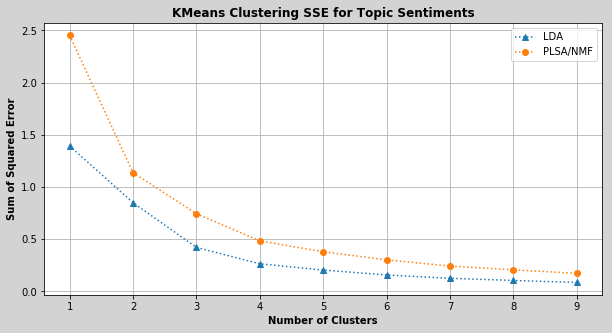

In [49]:
# Plot Results to Find Knee if One Exists
plt.figure(figsize=(10,5),facecolor='#d3d3d3')
plt.plot(X[0],X[1],':^',label = 'LDA')
plt.plot(X[0],X[2],':o',label = 'PLSA/NMF')
plt.ylabel('Sum of Squared Error',fontweight='bold')
plt.xlabel('Number of Clusters',fontweight='bold')
plt.legend(loc='best')
plt.grid()
_ = plt.title('KMeans Clustering SSE for Topic Sentiments',fontweight='bold')

### Initial Clustering Summary
For the quick clustering parameters, the LDA topic sentiments had a generally lower sum of squared errors than the PLSA topic model. Both models apear to have a knee in the 3 - 4 cluster range, as we saw duplicated in the hierarchical models.

### KMeans 4 Clusters on LDA and PLSA/NMF Topic Sentiments and Plot

In [50]:
def kmeans_wrapper(df, n_clusters_, msg):
    # Perform Kmeans
    t0 = time()
    print('Beginning Kmeans Clustering on %s Data with %d clusters...' % (msg,n_clusters_))
    km = KMeans(n_clusters=n_clusters_, init='k-means++', max_iter=300, n_init=1000, algorithm='full',
                        random_state=42, tol = 1e-8, verbose=0)
    km.fit(df[['neg','neu','pos']])
    # Label Topics
    df['Label'] = km.labels_
    print("completed in %0.3fs" % (time() - t0))
    return km,df


In [51]:
km_clusters_ = 4 # Number of clusters for Kmeans
km_nmf, km_nmf_df = kmeans_wrapper(km_nmf_df, km_clusters_, 'PLSA/NMF')
km_lda, km_lda_df = kmeans_wrapper(km_lda_df, km_clusters_, 'LDA')
done()

Beginning Kmeans Clustering on PLSA/NMF Data with 4 clusters...
completed in 39.080s
Beginning Kmeans Clustering on LDA Data with 4 clusters...
completed in 39.663s


## Plot Kmeans Results for LDA and PLSA/NMF

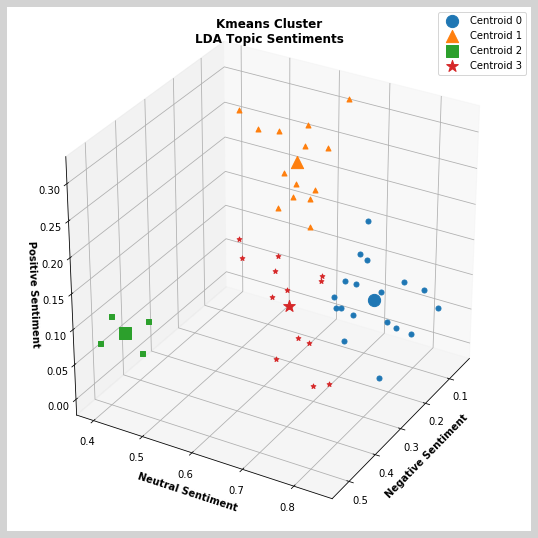

In [52]:
# Plot the results
ang = [(None,30)] #,(10,90),(100,0),(10,0)]
plot_clustering(km_lda.cluster_centers_,
                km_lda_df,'Kmeans Cluster\nLDA Topic Sentiments', ang)
 

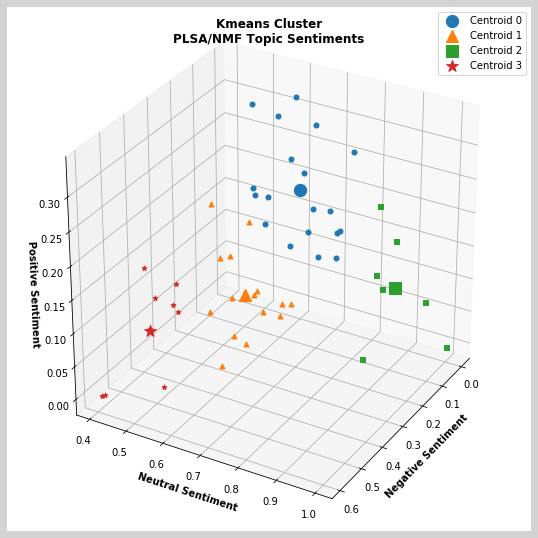

In [53]:
# Plot the results
ang = [(None,30)] #,(10,90),(100,0),(10,0)]
plot_clustering(km_nmf.cluster_centers_,
                km_nmf_df,'Kmeans Cluster\nPLSA/NMF Topic Sentiments', ang)
 

## Score KMeans Models

In [54]:
# Create DataFrame to Tabulate Model Scores
model_scores_df['KMeans LDA'] = np.append(score_model(km_lda_df),km_clusters_).reshape(-1,1) 
model_scores_df['KMeans PLSA/NMF'] = np.append(score_model(km_nmf_df),km_clusters_).reshape(-1,1) 
model_scores_df

Hierarchical LDA  Hierarchical PLSA/NMF  KMeans LDA  \
CH Score                 63.920187              59.160354   65.412290   
Silhouette Score          0.464105               0.391698    0.451274   
# Clusters                4.000000               4.000000    4.000000   

                  KMeans PLSA/NMF  
CH Score                62.244816  
Silhouette Score         0.406453  
# Clusters               4.000000

***
# GMM Clustering

In [55]:
# copy dataframe
gmm_lda_df = lda_sent_df.copy(deep=True)
gmm_nmf_df = nmf_sent_df.copy(deep=True)


score_gmm = lambda gmm,df: gmm.bic(df[['neg','neu','pos']])
cv_type = ['spherical', 'tied', 'diag', 'full']
X = []
for cv in cv_type:
    bld_gmm = lambda i: GMM(n_components=i, covariance_type=cv, max_iter=100, n_init = 10,
                     random_state=42, verbose = 0)
    X.append(run_nclusters(bld_gmm, score_gmm, gmm_lda_df, gmm_nmf_df, range_clusters=(2,10)))
done()

Clustering with n_clusters = 2 and model GaussianMixture(covariance_type='spherical', n_components=2, n_init=10,
                random_state=42)
completed in 0.067s
Clustering with n_clusters = 3 and model GaussianMixture(covariance_type='spherical', n_components=3, n_init=10,
                random_state=42)
completed in 0.076s
Clustering with n_clusters = 4 and model GaussianMixture(covariance_type='spherical', n_components=4, n_init=10,
                random_state=42)
completed in 0.077s
Clustering with n_clusters = 5 and model GaussianMixture(covariance_type='spherical', n_components=5, n_init=10,
                random_state=42)
completed in 0.087s
Clustering with n_clusters = 6 and model GaussianMixture(covariance_type='spherical', n_components=6, n_init=10,
                random_state=42)
completed in 0.086s
Clustering with n_clusters = 7 and model GaussianMixture(covariance_type='spherical', n_components=7, n_init=10,
                random_state=42)
completed in 0.094s
Clus

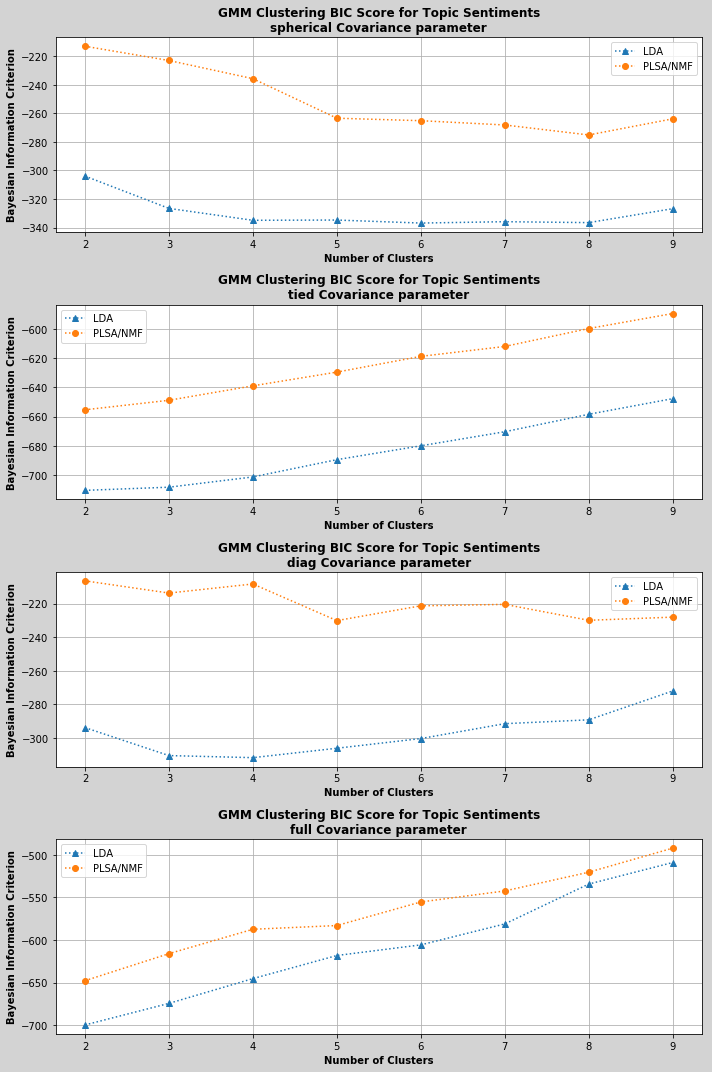

In [56]:
# Plot Results to Find Knee if One Exists
fig = plt.figure(tight_layout = True,figsize=(10,15),facecolor='#d3d3d3')
for i,x in enumerate(X):
    ax = fig.add_subplot(4,1,i+1)
    ax.plot(x[0],x[1],':^',label = 'LDA')
    ax.plot(x[0],x[2],':o',label = 'PLSA/NMF')
    ax.set_ylabel('Bayesian Information Criterion',fontweight='bold')
    ax.set_xlabel('Number of Clusters',fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True)
    t = 'GMM Clustering BIC Score for Topic Sentiments\n'
    t = t + '{} Covariance parameter'.format(cv_type[i])
    ax.set_title(t,fontweight='bold')

### BIC Results
It appears that the covariance parameter 'spherical' produces slightly better results (lower BIC is better). From that plot, it looks as though the LDA data should have 4 clusters and the PLSA/NMF 5.  We'll use 4 for continuity.

## Perform GMM Clustering and Plot Results

In [57]:
def gmm_wrapper(df, n_clusters_, msg):
    # Perform GMM
    t0 = time()
    print('Beginning GMM Clustering on %s Data with %d clusters...' % (msg,n_clusters_))
    mdl = GMM(n_components=n_clusters_, covariance_type='spherical', max_iter=300, n_init = 1000,
                     random_state=42, verbose = 0)
    mdl.fit(df[['neg','neu','pos']])
    # Label Topics
    df['Label'] = mdl.predict(df[['neg','neu','pos']])
    print("completed in %0.3fs" % (time() - t0))
    return mdl,df

gmm_lda_clusters = 4 # Number of clusters
gmm_nmf_clusters = 4
gmm_nmf, gmm_nmf_df = gmm_wrapper(gmm_nmf_df, gmm_nmf_clusters, 'PLSA/NMF')
gmm_lda, gmm_lda_df = gmm_wrapper(gmm_lda_df, gmm_lda_clusters, 'LDA')
done()

Beginning GMM Clustering on PLSA/NMF Data with 4 clusters...
completed in 4.083s
Beginning GMM Clustering on LDA Data with 4 clusters...
completed in 3.112s


## Plot GMM Results for LDA and PLSA/NMF

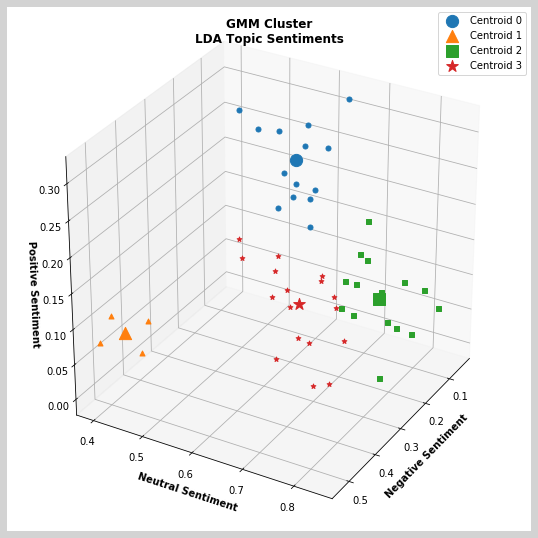

In [58]:
# Plot the results
ang = [(None,30)] #,(10,90),(100,0),(10,0)]
plot_clustering(gmm_lda.means_,
                gmm_lda_df,'GMM Cluster\nLDA Topic Sentiments', ang)
 

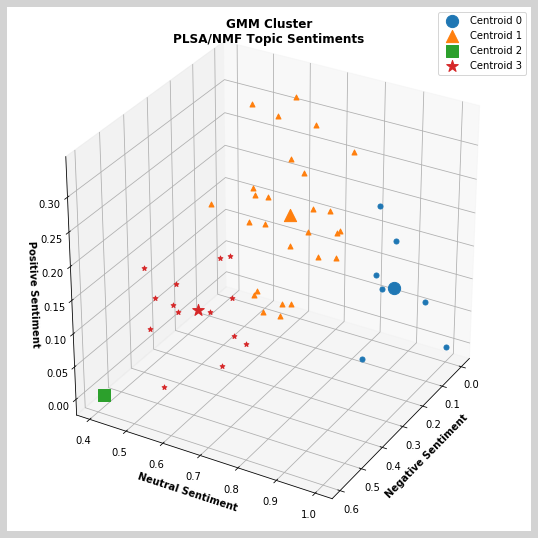

In [59]:
# Plot the results
ang = [(None,30)] #,(10,90),(100,0),(10,0)]
plot_clustering(gmm_nmf.means_,
                gmm_nmf_df,'GMM Cluster\nPLSA/NMF Topic Sentiments', ang)

## Score GMM Results

In [60]:
# Create DataFrame to Tabulate Model Scores
model_scores_df['GMM LDA'] = np.append(score_model(gmm_lda_df),gmm_lda_clusters).reshape(-1,1) 
model_scores_df['GMM PLSA/NMF'] = np.append(score_model(gmm_nmf_df),gmm_nmf_clusters).reshape(-1,1) 
model_scores_df

Hierarchical LDA  Hierarchical PLSA/NMF  KMeans LDA  \
CH Score                 63.920187              59.160354   65.412290   
Silhouette Score          0.464105               0.391698    0.451274   
# Clusters                4.000000               4.000000    4.000000   

                  KMeans PLSA/NMF    GMM LDA  GMM PLSA/NMF  
CH Score                62.244816  64.913570     43.074089  
Silhouette Score         0.406453   0.436603      0.356773  
# Clusters               4.000000   4.000000      4.000000

# DBSCAN Clustering

## Perform Nearest Neighbors to Find Initial Value of Epsilon
Epsilon is then maximum distance between two samples for one to be considered as in the neighborhood of the other. For brevity, only search the LDA dataset as it has out performed the NMF thus far.

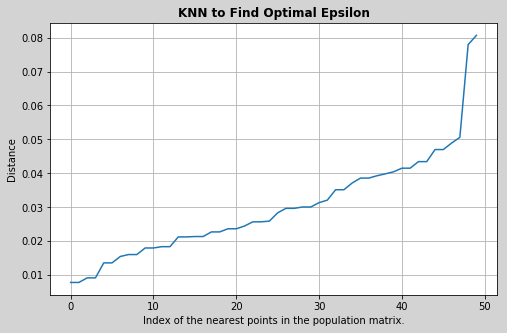

In [61]:
db_lda_df = lda_sent_df.copy(deep=True)
db_nmf_df = nmf_sent_df.copy(deep=True)

nn = NearestNeighbors(n_neighbors=6,algorithm='brute').fit(db_lda_df[['neg','neu','pos']])
distances, idx = nn.kneighbors(db_lda_df[['neg','neu','pos']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(8,5),facecolor='#d3d3d3')
plt.title('KNN to Find Optimal Epsilon',fontweight='bold')
plt.xlabel('Index of the nearest points in the population matrix.')
plt.ylabel('Distance')
plt.plot(distances)
_ = plt.grid()

## Grid Search to Fine Tune Epsilon and Minimum Samples 
Minimumn samples is the minimum number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

In [62]:
'''Setup Search Parameters'''
dbscan_eps = np.linspace(0.04, 0.08, 50)
dbscan_min_samp = np.arange(3,9)

EE, MS = np.meshgrid(dbscan_eps,dbscan_min_samp)
ee, ms = EE.flatten(), MS.flatten()
dbscan_no_clusters = np.zeros_like(ee)
dbscan_sil_scores = np.zeros_like(ee)
dbscan_ch_scores = np.zeros_like(ee)

# Build Small Test Set
np.random.seed(42)

'''Start Grid Search'''
print('Grid Search Sample Set Size: ',len(db_lda_df.index))
print('Beginning grid search on %d paramerter combinations...' % (len(ee)))
results = []
t0 = time()
for i in range(len(ee)):
    mdl  = DBSCAN(eps=ee[i], min_samples=ms[i])
    print('\nLoop %d, epsilon = %0.3f, min samples = %d' % (i, ee[i], ms[i]))
    mdl.fit(db_lda_df[['neg','neu','pos']])
    dbscan_no_clusters[i] = len(set(mdl.labels_)) - (1 if -1 in mdl.labels_ else 0)
    if dbscan_no_clusters[i] < 2:
        continue
    dbscan_sil_scores[i] = silhouette_score(db_lda_df[['neg','neu','pos']],
                                 mdl.labels_,metric='euclidean')
    dbscan_ch_scores[i] = calinski_harabasz_score(db_lda_df[['neg','neu','pos']],
                                       mdl.labels_)

clear_output(wait=True)
print('Grid Search Sample Set Size: ',len(db_lda_df.index))
print('Beginning grid search on %d paramerter combinations...' % (len(ee)))
print("Completed in %0.3fs." % (time() - t0))

'''Display Results'''
df_db_grid = pd.DataFrame({'Epsilon':ee, 'Min Samples':ms,
                           'No. Clusters':dbscan_no_clusters,
                           'Silhouette Score':dbscan_sil_scores,
                          'CH Score':dbscan_ch_scores})

best_sil = df_db_grid['Silhouette Score'].argmax()
best_ch = df_db_grid['CH Score'].argmax()
print('Best Silhouette Score:\n', df_db_grid.loc[best_sil])
print('Best CH Score:\n', df_db_grid.loc[best_ch])
done()


Grid Search Sample Set Size:  50
Beginning grid search on 300 paramerter combinations...
Completed in 1.602s.
Best Silhouette Score:
 Epsilon              0.062041
Min Samples          3.000000
No. Clusters         3.000000
Silhouette Score     0.382059
CH Score            20.383818
Name: 27, dtype: float64
Best CH Score:
 Epsilon              0.059592
Min Samples          3.000000
No. Clusters         3.000000
Silhouette Score     0.358113
CH Score            21.293836
Name: 24, dtype: float64


## Plot results of DBSCAN grid search

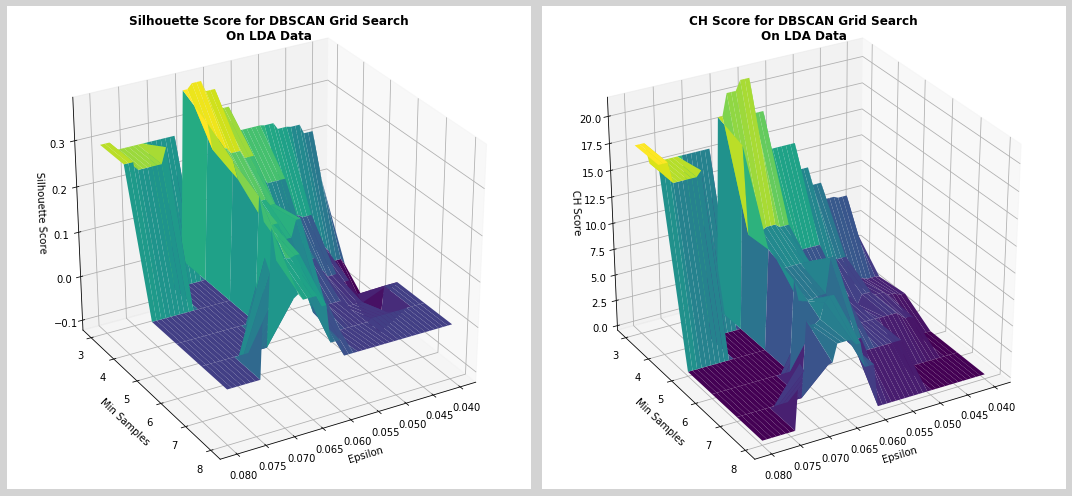

In [63]:
'''Plot Results of Grid Search'''
Z_sil = df_db_grid['Silhouette Score'].values.reshape(EE.shape)
Z_ch = df_db_grid['CH Score'].values.reshape(EE.shape)
fig = plt.figure(tight_layout=True,figsize=(15,7), facecolor='#d3d3d3')
titles = ['Silhouette Score for DBSCAN Grid Search\nOn LDA Data',
    'CH Score for DBSCAN Grid Search\nOn LDA Data']
zlbl = ['Silhouette Score','CH Score']
for i,Z in enumerate([Z_sil,Z_ch]):
    ax = fig.add_subplot(1,2,i+1, projection='3d')
    ax.plot_surface(EE, MS, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('Min Samples')
    ax.set_zlabel(zlbl[i])
    ax.set_title(titles[i],fontweight='bold')
    ax.view_init(None, 60)

### From the Grid Search, Best Min Samples is 3, and Best Epsilon is around 0.06

## Perform DBSCAN Clustering and Plot Results

In [64]:
lda_dbscan = DBSCAN(eps=0.06, min_samples=3)
def dbscan_wrapper(df, msg):
    # Perform DBSCAN
    t0 = time()
    print('Beginning DBSCAN Clustering on %s Data...' % (msg))
    mdl = DBSCAN(eps=0.06, min_samples=3)
    mdl.fit(df[['neg','neu','pos']])
    # Label Topics
    df['Label'] = mdl.labels_
    print("completed in %0.3fs" % (time() - t0))
    return mdl,df

db_nmf, db_nmf_df = dbscan_wrapper(db_nmf_df,'PLSA/NMF')
db_lda, db_lda_df = dbscan_wrapper(db_lda_df,'LDA')
done()

Beginning DBSCAN Clustering on PLSA/NMF Data...
completed in 0.004s
Beginning DBSCAN Clustering on LDA Data...
completed in 0.003s


## Plot DBSCAN Results

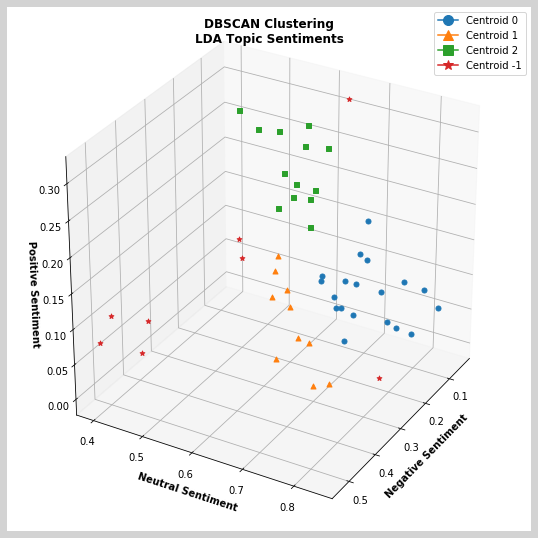

In [65]:
# Plot the results
ang = [(None,30)] #,(10,90),(100,0),(10,0)]
plot_clustering(None,db_lda_df,'DBSCAN Clustering\nLDA Topic Sentiments', ang)

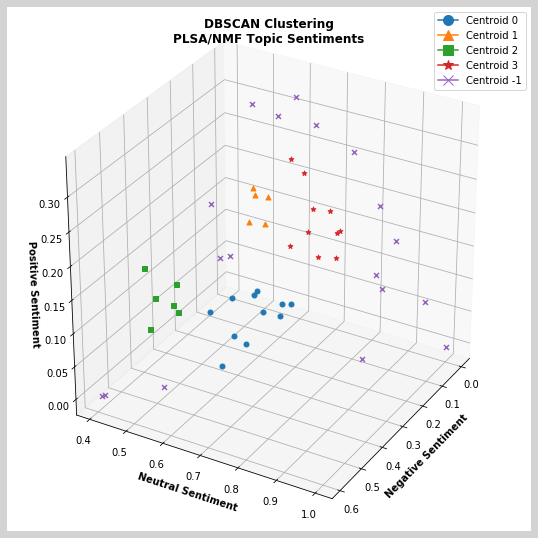

In [66]:
# Plot the results
ang = [(None,30)] #,(10,90),(100,0),(10,0)]
plot_clustering(None,db_nmf_df,'DBSCAN Clustering\nPLSA/NMF Topic Sentiments', ang)

## Score DBSCAN Model Filtering out Noise Labels

In [67]:
# filter out noise and count clusters
lda_filter = db_lda_df.Label >= 0
db_lda_clusters = len(set(db_lda_df[lda_filter].Label))
nmf_filter = db_nmf_df.Label >= 0
db_nmf_clusters = len(set(db_nmf_df[nmf_filter].Label))

ds_len = len(db_lda_df)

print('DBSCAN Percent Noise for LDA: ', (ds_len - len(db_lda_df[lda_filter]))/ds_len*100)
print('DBSCAN Percent Noise for PLSA/NMF: ', (ds_len - len(db_nmf_df[nmf_filter]))/ds_len*100)


# Create DataFrame to Tabulate Model Scores
model_scores_df['DBSCAN LDA'] = np.append(score_model(db_lda_df[lda_filter]),db_lda_clusters).reshape(-1,1) 
model_scores_df['DBSCAN PLSA/NMF'] = np.append(score_model(db_nmf_df[nmf_filter]),db_nmf_clusters).reshape(-1,1) 
model_scores_df

DBSCAN Percent Noise for LDA:  16.0
DBSCAN Percent Noise for PLSA/NMF:  36.0


Hierarchical LDA  Hierarchical PLSA/NMF  KMeans LDA  \
CH Score                 63.920187              59.160354   65.412290   
Silhouette Score          0.464105               0.391698    0.451274   
# Clusters                4.000000               4.000000    4.000000   

                  KMeans PLSA/NMF    GMM LDA  GMM PLSA/NMF  DBSCAN LDA  \
CH Score                62.244816  64.913570     43.074089   49.645517   
Silhouette Score         0.406453   0.436603      0.356773    0.456330   
# Clusters               4.000000   4.000000      4.000000    3.000000   

                  DBSCAN PLSA/NMF  
CH Score                60.763639  
Silhouette Score         0.504851  
# Clusters               4.000000

# Interpereting Results
The KMeans LDA model appears to be the best model. DBSCAN PLSA performed well too, but it classified 36% of the points as noise making it's results less desirable in context. 

## Plot Kmeans LDA Model From Several Angles to Better Inspect

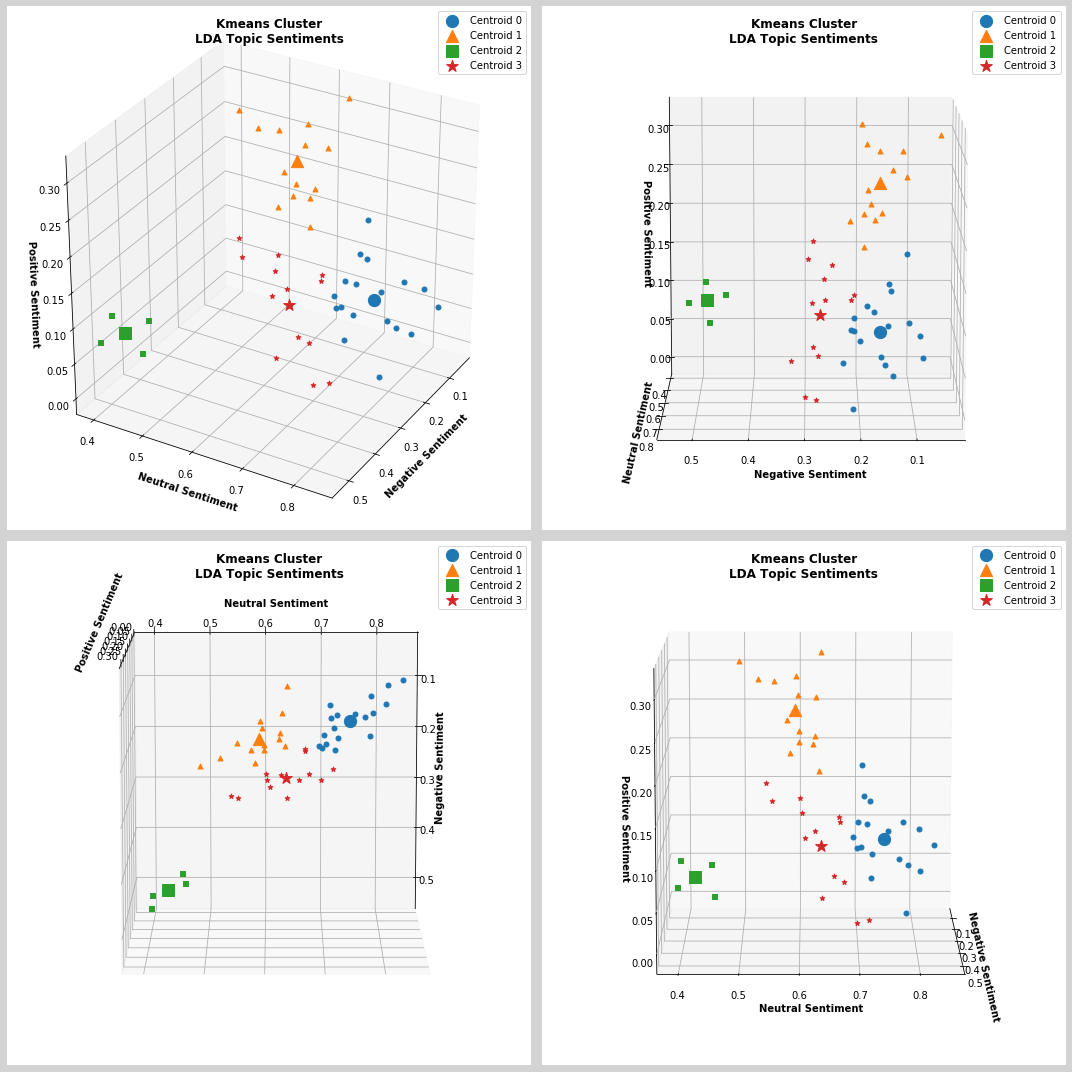

In [68]:
# Plot the results
ang = [(None,30),(10,90),(100,0),(10,0)]
plot_clustering(km_lda.cluster_centers_,
                km_lda_df,'Kmeans Cluster\nLDA Topic Sentiments', ang)

***
# Process the Test Data by Scoring for Sentiment Only on The Features From the LDA Topic Model

## Vectorize Test Data With LDA Topic Model Vocabulary

In [69]:
# Build A Vectorizer Based on Topic Model Vocabulary
lda_topic_vocab = {}
for i,token in enumerate(tf_feature_names):
    # key must be feature name and value is index
    lda_topic_vocab[token] = i

# Vectorize test data
tf_test_vectorizer = CountVectorizer(lowercase=False, 
                                     ngram_range=(1,2),
                                     vocabulary=lda_topic_vocab)
tf_test = tf_test_vectorizer.fit_transform(totalDF.loc[idx_test].Cleaned)
tf_test_names = tf_test_vectorizer.get_feature_names()

# Check that vocabularies are the same
for i,key in enumerate(lda_topic_vocab.keys()):
    if tf_test_names[i] != key:
        print('\n'+'='*25)
        print('Index %d vocab not matching' % i)
        print('LDA Vocab: {}'.format(tf_test_names[i]))
        print('Test Vect Vocab: {}'.format(key))

### Inspect the Test Data

In [70]:
def display_vect_words(vect,names,n_display):
    for i in range(n_display):
        print("Test Sample {:d} =====================".format(i))
        idx = vect[i,:].nonzero()[1]
        print("|".join([names[k] for k in idx]))

display_vect_words(tf_test,tf_test_names,10)

Test Sample 0 =====================
hand|korea|park|south|south korea|verdict
Test Sample 1 =====================
australia|save
Test Sample 2 =====================
suspect|theft
Test Sample 3 =====================
bomber|return|uk
Test Sample 4 =====================
saturday|wrap
Test Sample 5 =====================
announced|asbestos|panel|response
Test Sample 6 =====================
drought|music|relief
Test Sample 7 =====================
join|olympics|woman
Test Sample 8 =====================
could|model|water
Test Sample 9 =====================
adelaide|birthday|festival


In [71]:
# Build Test DataFrame with Sentiment Score for Each Entry
def sent_score_test_data(tf_matrix, tf_names, sentAnalyzer):
    t0 = time()
    print('Beginning Sentiment Scoring on %d entries...' % tf_matrix.shape[0])
    sent_list = []
    for i in range(tf_matrix.shape[0]):
        idx = np.array(list(tf_test[i,:].nonzero()[1]), dtype = 'int32')
        quant = [tf_matrix[i,j] for j in idx]
        words = [tf_names[j] for j in idx]
        s = []
        for k in range(len(quant)):
            for l in range(quant[k]):
                s = s + [words[k]]
        sent_list.append(sentAnalyzer.polarity_scores(' '.join(s)))
    print("Completed in %0.3fs." % (time() - t0))
    return pd.DataFrame(sent_list)


In [72]:
'''Score the Test Data'''
vsia = vader.SentimentIntensityAnalyzer()
testDF = sent_score_test_data(tf_test, tf_test_names, vsia)
display(testDF.head())
done()

Beginning Sentiment Scoring on 314907 entries...
Completed in 97.210s.


compound    neg    neu    pos
0    0.5859  0.000  0.510  0.490
1    0.4939  0.000  0.238  0.762
2   -0.2960  0.688  0.312  0.000
3    0.0000  0.000  1.000  0.000
4    0.0000  0.000  1.000  0.000

## Test KMeans Model by Bootstrapping CH and Silhouette Scores

In [73]:
def boot_strap_results(test_df, mdl, n_folds = 2000 ,n_samples = 50):
    t0 = time()
    print('Beginning testing clustering model with %d samples and %d folds'\
          % (n_samples,n_folds))
    print('With model {}'.format(mdl))
    results = []
    for k in range(n_folds):
        df = test_df.sample(n=n_samples, replace = False,
                      random_state = k)
        df['Label'] = mdl.predict(df[['neg','neu','pos']])
        if len(set(df.Label)) > 1:
            ch,sil = score_model(df)
            results.append({'CH Score':ch, 'Silhouette Score':sil})
    print("Completed in %0.3fs." % (time() - t0))
    return pd.DataFrame(results)

In [74]:
test_results_df = boot_strap_results(testDF,km_lda)
display(test_results_df.head(10))
display(test_results_df.describe())
done()

Beginning testing clustering model with 50 samples and 2000 folds
With model KMeans(algorithm='full', n_clusters=4, n_init=1000, random_state=42, tol=1e-08)
Completed in 30.304s.


CH Score  Silhouette Score
0  109.253418          0.741201
1   71.549669          0.662645
2  107.332098          0.646145
3   61.531661          0.364559
4  107.650287          0.666073
5   67.004170          0.516775
6  104.068073          0.672356
7   85.222724          0.676210
8   48.699477          0.550615
9   69.871843          0.639992

CH Score  Silhouette Score
count  2000.000000       2000.000000
mean    107.119269          0.659873
std      44.175669          0.076415
min      42.242472          0.364559
25%      76.818871          0.608043
50%      96.253290          0.660825
75%     125.180427          0.711906
max     379.050637          0.893939

In [75]:
def plot_result_box_dist(data, title):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                        facecolor='#d3d3d3',
                                        figsize=(10,5),
                                        gridspec_kw= {"height_ratios": (0.2, 1)})
    z95 = 1.96      # zscore for 95%
    N = len(data)
    d = round(N*0.95/2)     # get middle 95% of values

    # Get Bootstrapped Confidence Interval and Add to Plot
    ci_values = data.sort_values()
    ci = (ci_values[0+d],ci_values[N-1-d])      # store 95% confidence interval
    md = ci_values.mean()

    # plot box plot
    sns.boxplot(data, ax=ax_box)
    # plot distribution
    sns.kdeplot(data, shade=True, ax=ax_hist)
    ax_hist.axvline(md,0,10,color='g',linestyle='solid',label='Mean = {:0.3f}'.format(md))
    ax_hist.axvline(ci[0],0,10,color='r',linestyle='dotted')
    ax_hist.axvline(ci[1],0,10,color='r',linestyle='dotted',
              label='95% CI =\n({:0.3f}, {:0.3f})'.format(*ci))
    ax_hist.set(xlabel=data.name)
    ax_hist.legend(loc='best')
    ax_box.set(xlabel='')
    ax_box.set_title(title,fontweight='bold')

## Plot Results of Bootstrapping

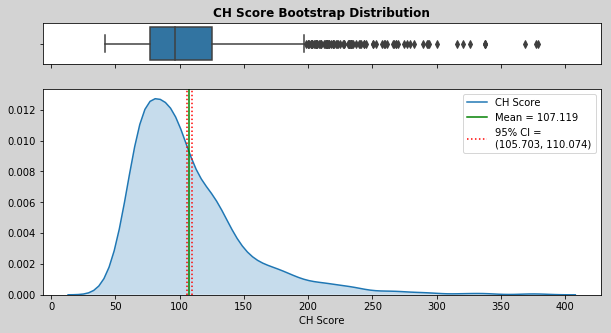

In [76]:
'''Plot Results'''
plot_result_box_dist(test_results_df['CH Score'],'CH Score Bootstrap Distribution')

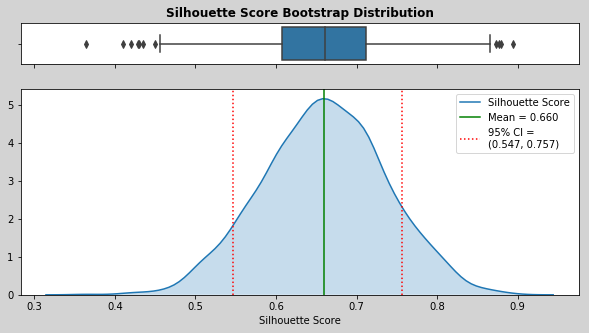

In [77]:
plot_result_box_dist(test_results_df['Silhouette Score'],'Silhouette Score Bootstrap Distribution')

## Compare Other LDA Models Against Kmeans LDA as "Ground Truth"

### Find Closest Point to Kmeans Center for Each Cluster

In [78]:
# Align Labels Between Models to Kmeans Nomenclature
conf_df = lda_sent_df.copy(deep=True)

# Find Closest Point to Each CLuster Center and Use to Find Matching Label in 
#...other models
label_dict = {}
for center in km_lda.cluster_centers_:
    closest_pnt = cosine_similarity(center.reshape(1,-1),conf_df[['neg','neu','pos']]).argmax()
    label_dict[km_lda.predict(center.reshape(1,-1))[0]] = [center,closest_pnt]
print('Kmeans Label: Kmeans Center, Closest Data Point to Center')
display(label_dict)

    

Kmeans Label: Kmeans Center, Closest Data Point to Center


{0: [array([0.16377778, 0.74905556, 0.08705556]), 26],
 1: [array([0.15964286, 0.59057143, 0.24985714]), 21],
 2: [array([0.4905 , 0.42675, 0.08325]), 8],
 3: [array([0.27185714, 0.63628571, 0.09171429]), 47]}

### Inspect Topics Closest to Each Center

In [95]:

def display_topic(model, comp_index, label, feature_names, no_top_words):
    print("Cluster {:d}, Centroid Topic {:d} =====================".format(label,comp_index))
    idx = (-model.components_[comp_index,:]).argsort()[:no_top_words]
    print("|".join([feature_names[k] for k in idx]))
    print()


for key in label_dict.keys():
    display_topic(lda, label_dict[key][-1],key, tf_feature_names, 10)
    

Cluster 0, Centroid Topic 26 =====================
plan|australia|job|fear|test|nt|leader|mine|opposition|river

Cluster 1, Centroid Topic 21 =====================
election|help|law|act|air|keep|light|syria|northern|problem

Cluster 2, Centroid Topic 8 =====================
woman|accused|dead|melbourne|lead|sex|study|chinese|spark|teacher

Cluster 3, Centroid Topic 47 =====================
china|case|centre|move|mayor|korea|warns|uk|stand|north korea



### Align the Labeling Between Algorithms for Comparison

In [79]:
# Build Master DataFrame with Labels from All Models
cols = ['Kmeans Label', 'Heirarchical Label', 'GMM Label', 'DBSCAN Label']
for i,mdl_df in enumerate([km_lda_df, hc_lda_df, gmm_lda_df, db_lda_df]):
    conf_df[cols[i]] = mdl_df['Label']

closest_points_to_centers = [label_dict[key][1] for key in label_dict.keys()]
rosetta_df = conf_df.loc[closest_points_to_centers][cols].set_index(cols[0])
print('Label Rosetta Stone ' + '='*30)
display(rosetta_df)

Label Rosetta Stone ==============================


Heirarchical Label  GMM Label  DBSCAN Label
Kmeans Label                                             
0                              0          2             0
1                              2          0             2
2                              3          1            -1
3                              1          3             1

DBSCAN Noise Label Changed to Cluster 3 to align with label space of the other 3 models

In [80]:
'''Fix Labeling '''
adj_lbls = ['KMeans Adj.','Heirarchical Adj.', 'GMM Adj.', 'DBSCAN Adj.']
conf_df[adj_lbls[0]] = conf_df[cols[0]]  # copy over kmeans labels

# change -1 label to 3 for DBSCAN
conf_df[cols[-1]][conf_df[cols[-1]] < 0] = 3   
rosetta_df.loc[2,cols[-1]]  = 3

for i in range(1,len(cols),1):
    # build converter function
    converter = rosetta_df[cols[i]].values.argsort() # array of indicies that would sort the labels
    fconvert = lambda x:converter[x]
    conf_df[adj_lbls[i]] = conf_df[cols[i]].apply(fconvert)
    rosetta_df[adj_lbls[i]] = rosetta_df[cols[i]].apply(fconvert)

display(rosetta_df)
display(conf_df.loc[closest_points_to_centers])

Heirarchical Label  GMM Label  DBSCAN Label  Heirarchical Adj.  \
Kmeans Label                                                                   
0                              0          2             0                  0   
1                              2          0             2                  1   
2                              3          1             3                  2   
3                              1          3             1                  3   

              GMM Adj.  DBSCAN Adj.  
Kmeans Label                         
0                    0            0  
1                    1            1  
2                    2            2  
3                    3            3

compound    neg    neu    pos  Kmeans Label  Heirarchical Label  \
26   -0.4939  0.149  0.756  0.095             0                   0   
21    0.5106  0.183  0.577  0.239             1                   2   
8    -0.9786  0.495  0.401  0.104             2                   3   
47   -0.8555  0.272  0.637  0.091             3                   1   

    GMM Label  DBSCAN Label  KMeans Adj.  Heirarchical Adj.  GMM Adj.  \
26          2             0            0                  0         0   
21          0             2            1                  1         1   
8           1             3            2                  2         2   
47          3             1            3                  3         3   

    DBSCAN Adj.  
26            0  
21            1  
8             2  
47            3

In [81]:
'''Display Confusion Matrix'''
def add_confusion_matrix(df, ref_col, compare_col, ax):
    conf_mx = confusion_matrix(df[ref_col],df[compare_col])
    np.fill_diagonal(conf_mx,0)
    sns.heatmap(conf_mx, annot=True, ax=ax, cmap='Oranges', 
               linewidths = 1,linecolor='#2b2d2f',cbar=False)
    r = ref_col.split(' ')[0]
    c = compare_col.split(' ')[0]
    ax.set_ylabel(r + ' Labels', fontweight='bold')
    ax.set_xlabel(c + ' Labels', fontweight = 'bold')
    _= ax.set_title('LDA Models Confusion Matrix: {}\n Compared Against {}'.format(r,c),
                fontweight='bold')
    return None

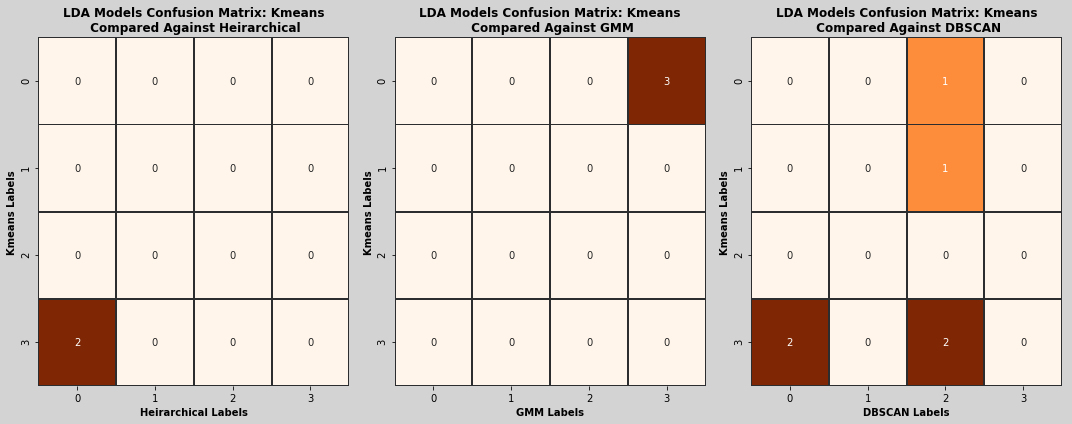

In [82]:
fig, axes = plt.subplots(1,3, facecolor='#d3d3d3',figsize=(15,6),
                        tight_layout = True)
axes = axes.ravel()
for i,ax in enumerate(axes):
    add_confusion_matrix(conf_df, cols[0],adj_lbls[i+1],ax)

In [83]:
#Show Points In Disagreement
miss_labeled = []
for lbl in adj_lbls:
    if not('kmeans' in lbl.lower()):
        print('='*40)
        s = [adj_lbls[0],lbl]
        miss_labeled.append(conf_df[conf_df[lbl] != conf_df[adj_lbls[0]]][s])
        display(miss_labeled[-1])
    

KMeans Adj.  Heirarchical Adj.
0             3                  0
48            3                  0

KMeans Adj.  GMM Adj.
10            0         3
13            0         3
49            0         3

KMeans Adj.  DBSCAN Adj.
0             3            0
12            1            2
19            3            2
36            0            2
43            3            2
48            3            0

## Perfrom PCA and Graph Points in Disagreement

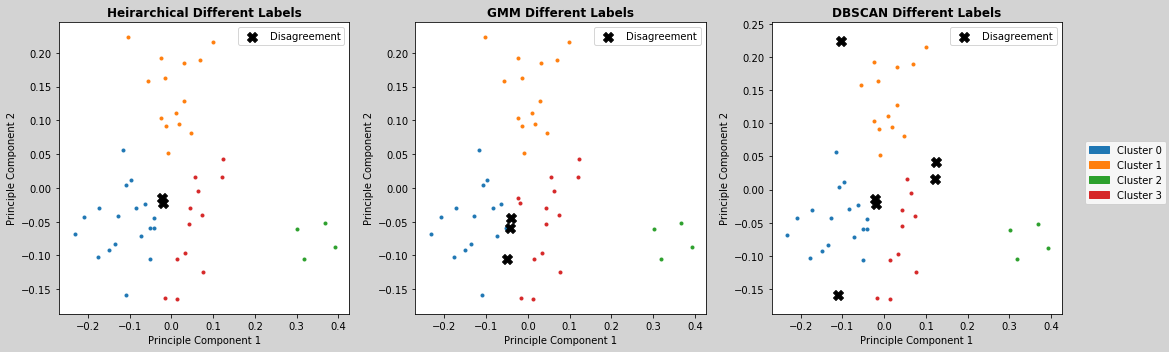

In [88]:
pca = PCA(n_components=2)
X = pca.fit_transform(conf_df[['neg','neu','pos']])

# build custom legend
le = []
for i in range(4):
    le.append(Patch(facecolor=COLORS[i], 
                    edgecolor=COLORS[i],
                    label='Cluster {:d}'.format(i)))

fig, axes = plt.subplots(nrows=1,ncols=3,tight_layout=True,
                 facecolor = '#d3d3d3',figsize=(15,5))
axes = axes.ravel()
for j,ml in enumerate(miss_labeled):
    for i in range(4):
        idx = conf_df['KMeans Adj.'] == i
        axes[j].scatter(X[idx,0],X[idx,1],marker='.',color = COLORS[i])
    idx = ml.index
    s = ml.columns[-1].split(' ')[0] + ' Different Labels'
    axes[j].scatter(X[idx,0],X[idx,1],marker='X',color = 'k',label='Disagreement',s = 100)
    axes[j].set_title(s,fontweight='bold')
    axes[j].set_ylabel('Principle Component 2')
    axes[j].set_xlabel('Principle Component 1')
    _ = axes[j].legend(loc='upper right')

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
fig.legend(handles=le,loc='upper left',bbox_to_anchor = (1,.6),ncol=1)
fig.tight_layout()